In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
# numpyro.set_platform("cpu")

In [4]:
# numpyro.set_host_device_count(4)

# Prepare data

In [5]:
data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

# data = data.query("year == 1996")
data = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

data.head(3)

year      industry                 occup   exp        salary  sex  \
0  1997  info/culture          other trades   5.0  78385.474860    0   
1  1997         trade   clerical/supervisor   1.0  32225.139665    0   
2  1997     utilities  operators/assemblers  12.0  62708.379888    0   

   elementary_edu  highschool_edu  postsec_edu  undergrad_edu  ...  \
0               0               0            1              0  ...   
1               0               1            0              0  ...   
2               0               0            0              1  ...   

   grad_college_refyear  grad_univ_refyear  tenure  union  part_time  \
0                     0                  0    55.0      0          0   
1                     0                  0    13.0      0          0   
2                     0                  0   138.0      1          0   

   public_sector  self_emp   age  firm_size  loc_size  
0              0         0  26.0          1         1  
1              0         0  34.0          2         2  
2              1         0  34.0          3         3  

[3 rows x 22 columns]

In [6]:
#data.to_csv("../Numpyro/clean_dataset.csv", index=False)

# Dynamically update model

In [7]:
dataset = data.copy()

In [8]:
from GammaGLM import GammaGLM

In [9]:
gamma = GammaGLM("test", "pooled", dataset, "salary", ["exp","undergrad_edu"], "industry", ["exp","age","tenure"])
gamma

TypeError: GammaGLM.__init__() missing 1 required positional argument: 'OUTPUTS_PATH'

In [10]:
gamma.build()

NameError: name 'gamma' is not defined

In [11]:
gamma.run()

<class 'method'>


sample: 100%|██████████| 4000/4000 [00:53<00:00, 74.20it/s] 


AttributeError: 'GammaGLM' object has no attribute 'outputs_path'

In [12]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

DISTRIBUTIONS = {
    "normal": dist.Normal,
    "half_normal": dist.HalfNormal,
    "student_t": dist.StudentT,
    "laplace": dist.Laplace,
    "uniform": dist.Uniform,
    "gamma": dist.Gamma,
    "lognormal": dist.LogNormal
}

def pooled(features, target, prior_dist="normal", prior_params={"loc": 0, "scale": 1}, shape_dist="uniform", shape_params={"low": 1, "high": 100}, target_dist="gamma"):
    beta = numpyro.sample("beta", DISTRIBUTIONS[prior_dist](**prior_params), sample_shape=(features.shape[1],))
    shape = numpyro.sample("shape", DISTRIBUTIONS[shape_dist](**shape_params))
    mu = jnp.exp(jnp.dot(features, beta))
    rate = shape / mu
    numpyro.sample("salary_hat", DISTRIBUTIONS[target_dist](concentration=shape, rate=rate), obs=target)

def hierarchical(features, target, industry, prior_dist="normal", prior_params={"loc": 0, "scale": 1}, shape_dist="uniform", shape_params={"low": 1, "high": 100}, target_dist="gamma"):
    mu_beta = numpyro.sample("mu_beta", DISTRIBUTIONS[prior_dist](**prior_params), sample_shape=(features.shape[1],))
    sigma_beta = numpyro.sample("sigma_beta", DISTRIBUTIONS[shape_dist](**shape_params), sample_shape=(features.shape[1],))
    offset = numpyro.sample("offset", DISTRIBUTIONS["normal"](loc=0, scale=1), sample_shape=(features.shape[1], industry.max()+1))
    beta = numpyro.deterministic("beta", mu_beta[:, None] + offset * sigma_beta[:, None])
    shape = numpyro.sample("shape", DISTRIBUTIONS[shape_dist](**shape_params))
    mu = jnp.exp(jnp.dot(features, beta[: ,industry]))
    rate = shape / mu
    numpyro.sample("salary_hat", DISTRIBUTIONS[target_dist](concentration=shape, rate=rate), obs=target)

# numpyro.render_model(hierarchical, model_args=(features, target, industry), render_distributions=True)

In [35]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(hierarchical, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='vectorized', progress_bar=True)
mcmc.run(rng_key, features, target, industry)
trace = az.from_numpyro(mcmc)

I0000 00:00:1696342125.552477   12854 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
sample: 100%|██████████| 2000/2000 [1:00:21<00:00,  1.81s/it]
W0000 00:00:1696345751.428208   12854 hlo_rematerialization.cc:2946] Can't reduce memory use below 605.99MiB (635423346 bytes) by rematerialization; only reduced to 2.43GiB (2605067160 bytes), down from 2.43GiB (2605067224 bytes) originally
W0000 00:00:1696345752.263237   12854 hlo_rematerialization.cc:2946] Can't reduce memory use below -1.71GiB (-1836825006 bytes) by rematerialization; only reduced to 2.42GiB (2604416000 bytes), down from 2.42GiB (2604416000 bytes) originally
2023-10-03 11:09:22.279081: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.42GiB (rounded to 2604416000)requested by op 
2023-10-03 11:09:22.279212: W external/tsl/tsl/framework/bfc_allocator.cc:497] *************************************************************************************_______________

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2604416000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.42GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.42GiB
     preallocated temp allocation:         0B
                 total allocation:    4.85GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.42GiB
		Entry Parameter Subshape: f64[4000,81388]
		==========================

	Buffer 2:
		Size: 2.42GiB
		XLA Label: fusion
		Shape: f64[4000,81388]
		==========================



In [13]:
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, util
from numpyro.infer.util import log_likelihood
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import datetime
import xarray as xr

# jax.config.update("jax_enable_x64", True)

data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

data = data.query("year == 2011").copy()
data = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

data.head(3)
dataset = data.copy()

dataset["exp"] = (dataset["exp"] - dataset["exp"].mean()) / dataset["exp"].std()
dataset["age"] = (dataset["age"] - dataset["age"].mean()) / dataset["age"].std()
dataset["tenure"] = (dataset["tenure"] - dataset["tenure"].mean()) / dataset["tenure"].std()

features = dataset[['exp','sex']].values #,'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                # 'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                # 'public_sector','self_emp','age']].values
target = dataset['salary'].values
industry = pd.factorize(dataset['industry'])[0]
industry_cats = pd.factorize(dataset['industry'])[1]

import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

DISTRIBUTIONS = {
    "normal": dist.Normal,
    "half_normal": dist.HalfNormal,
    "student_t": dist.StudentT,
    "laplace": dist.Laplace,
    "uniform": dist.Uniform,
    "gamma": dist.Gamma,
    "lognormal": dist.LogNormal
}

def hierarchical(features, target, industry):
    mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
    sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
    mu_hyperpriors = [mu_avg_salary]
    sigma_hyperpriors = [sigma_avg_salary]
    for i in range(features.shape[1]):
        mu_hyperpriors.append(numpyro.sample(f"mu_{i}", dist.Normal(loc=0, scale=1)))
        sigma_hyperpriors.append(numpyro.sample(f"sigma_{i}", dist.HalfNormal(scale=1)))
    
    with numpyro.plate("industry", industry.max()+1):
        avg_salary = numpyro.sample("avg_salary", dist.Normal(loc=0, scale=1))
        priors = []
        for i in range(features.shape[1]):
            offset = numpyro.sample(f"offset_{i}", dist.Normal(loc=0, scale=1))
            prior = numpyro.deterministic(f"prior_{i}", mu_hyperpriors[i] + offset * sigma_hyperpriors[i])
            priors.append(prior)
    shape = numpyro.sample("shape", dist.Uniform(low=1, high=100))
    mu = avg_salary[industry]
    for i, prior in enumerate(priors):
        mu += prior[industry] * features[:,i]
    mu = jnp.exp(mu)
    rate = shape / mu
    with numpyro.plate("data", target.shape[0]):
        numpyro.sample("salary_hat", dist.Gamma(concentration=shape, rate=rate), obs=target)

numpyro.render_model(hierarchical, model_args=(features, target, industry), render_distributions=True)

def concat_samples(samples):
    for key in samples[0]:
        samples[0][key] = jnp.concatenate([samples[0][key], samples[1][key]], axis=1)
    return samples[0]

def create_inference_data(mcmc,
                          samples, 
                          divergences, 
                          loglikelihood, 
                          dimension_name, 
                          dimension,
                          target):
    trace = az.from_numpyro(mcmc)
    chains, draws, dim = samples["avg_salary"].shape
    obs = target.shape[0]

    posterior_dataset = xr.Dataset(
        data_vars = { var: (["chain", "draw", f"{dimension_name}"], samples[var]) 
                     if len(samples[var].shape)==3 else (["chain", "draw"], samples[var])
                     for var in samples.keys()  },
        coords = { "chain": np.arange(chains), "draw": np.arange(draws), f"{dimension_name}": dimension },
        attrs = trace.posterior.attrs,
    )
    loglike_dataset = xr.Dataset(
        data_vars=dict(log_likelihood=(["chain", "draw", "obs"], loglikelihood)),
        coords=dict(chain=np.arange(chains), draw=np.arange(draws), obs=np.arange(obs)),
        attrs=trace.log_likelihood.attrs
    )
    sample_stats = xr.Dataset(
        data_vars=dict(diverging=(["chain", "draw"], divergences)),
        coords=dict(chain=np.arange(chains),draw=np.arange(draws)),
        attrs=trace.sample_stats.attrs,
    )
    observed_data = xr.Dataset(
        data_vars=dict(salary=(["obs"], target)),
        coords=dict(obs=np.arange(obs)),
        attrs=trace.observed_data.attrs,
    )

    return az.InferenceData(posterior=posterior_dataset,
                 log_likelihood=loglike_dataset,
                 sample_stats=sample_stats,
                 observed_data=observed_data)

def create_mcmc(model, warmup, samples, chains, last_sample=None):
    kernel = NUTS(model, target_accept_prob=0.95, init_strategy=init_to_median(num_samples=100))
    return MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method='vectorized', progress_bar=True)

def get_batch_results(model, mcmc, divergences, loglikehood, iteration, chains, nsamples, obs):
    model_args = {"features":features, "target": target, "industry": industry}
    samples = mcmc.get_samples(group_by_chain=True)
    sample_rhat = az.summary(az.from_dict(mcmc.get_samples(group_by_chain=True)))["r_hat"].max()
    cumulative_rhat = az.summary(az.from_dict(samples),round_to=5)["r_hat"].max()
    if iteration == 0:
        divergences = mcmc.get_extra_fields(group_by_chain=True)["diverging"]
        loglikehood = log_likelihood(model = model,
                                     posterior_samples = mcmc.get_samples(), 
                                     batch_ndims = 1,
                                     **model_args)["salary_hat"]\
                                     .reshape(chains, nsamples, obs)
    else:
        divergences = jnp.concatenate([divergences, mcmc.get_extra_fields(group_by_chain=True)["diverging"]], axis=1)
        loglikehood = jnp.concatenate([loglikehood,log_likelihood(model = model,
                                                                  posterior_samples = mcmc.get_samples(),
                                                                  batch_ndims = 1,
                                                                  **model_args)["salary_hat"]\
                                                                  .reshape(chains, nsamples, obs)], axis=1)
    return samples, divergences, loglikehood, sample_rhat, cumulative_rhat


# Initial run settings
iterations = 10
prev_rhat = 10e10
nwarmup = 100
nsamples = 100
chains = 4
last_sample = None
mcmc = create_mcmc(hierarchical, nwarmup, nsamples, chains)
divergences = None
loglikehood = None
nsample_updated = False
model_args = {"features":features, "target": target, "industry": industry}

# Run NUTS
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
for it in range(iterations):
    if it == 0:
        mcmc.run(rng_key, features, target, industry)
    elif nsample_updated:
        mcmc.run(rng_key, features, target, industry, init_params=last_sample)
        # nsample_updated = False
    else:
        mcmc.post_warmup_state = mcmc.last_state
        mcmc.run(mcmc.post_warmup_state.rng_key, features, target, industry)
        
    samples, divergences, loglikehood, sample_rhat, cumulative_rhat = get_batch_results(hierarchical,
                                                                                        mcmc,
                                                                                        divergences,
                                                                                        loglikehood,
                                                                                        it,
                                                                                        chains,
                                                                                        nsamples,
                                                                                        target.shape[0])
    print(f"It:{it} - sample rhat: {sample_rhat} - cumulative rhat: {cumulative_rhat}")
    if cumulative_rhat < 1.01:
        print(f"Model converged at iteration: {it} with {loglikehood.shape[1]} samples")
        break
    if prev_rhat - cumulative_rhat < 0.01:
        last_sample = {k: v[:,-1] for k, v in mcmc.get_samples(group_by_chain=True).items()}
        nwarmup += 100
        nsamples += 100
        mcmc = create_mcmc(hierarchical, nwarmup, nsamples, chains)
        nsample_updated = True
        print(f"Increasing warmup to {nwarmup} and samples to {nsamples}")
    prev_rhat = cumulative_rhat
    

# kernel = NUTS(hierarchical, target_accept_prob=0.95, init_strategy=init_to_median(num_samples=100))
# mcmc = MCMC(kernel, num_warmup=200, num_samples=200, num_chains=4, chain_method='vectorized', progress_bar=True)
# mcmc.run(rng_key, features, target, industry)


# print(f"sample rhat: {sample_rhat} - cumulative rhat: {cumulative_rhat}")

# iterations= 10
# last_sample = None
# for it in range(iterations):
#     prev_cumulative_rhat = cumulative_rhat
#     mcmc.post_warmup_state = None
#     if last_sample is not None:
#         new_mcmc.post_warmup_state = None
#         new_mcmc.run(rng_key, features, target, industry)
#         new_samples = mcmc.num_samples
#     else:
#         mcmc.run(rng_key, features, target, industry)
#         new_samples = mcmc.num_samples
#     samples = concat_samples([samples, mcmc.get_samples(group_by_chain=True)])
#     divergences = jnp.concatenate([divergences, mcmc.get_extra_fields(group_by_chain=True)["diverging"]], axis=1)
#     loglikehood = jnp.concatenate([loglikehood, numpyro.infer.log_likelihood(model=hierarchical, posterior_samples=mcmc.get_samples(), batch_ndims=1, **model_args)["salary_hat"].reshape(4, new_samples,4515)], axis=1)
#     sample_rhat = az.summary(az.from_dict(mcmc.get_samples(group_by_chain=True)))["r_hat"].max()
#     cumulative_rhat = az.summary(az.from_dict(samples), round_to=5)["r_hat"].max()
#     print(f"It:{it} - sample rhat: {sample_rhat} - cumulative rhat: {cumulative_rhat}")
#     if cumulative_rhat < 1.01:
#         break
#     rhat_diff = prev_cumulative_rhat - cumulative_rhat
#     if rhat_diff < 0.01:
#         new_warmup = mcmc.num_warmup + 100
#         new_samples = mcmc.num_samples + 100
#         last_sample = mcmc.get_samples(group_by_chain=True)
#         new_kernel = NUTS(hierarchical, target_accept_prob=0.95, init_strategy=init_to_median(num_samples=100))
#         new_mcmc = MCMC(new_kernel, num_warmup=new_warmup, num_samples=new_samples, num_chains=4, chain_method='vectorized', progress_bar=True)
#         print(f"Increasing warmup to {new_warmup} and samples to {new_samples}")

# trace = create_inference_data(mcmc, samples, divergences, loglikehood, "industry", industry_cats, target)
# trace





# mcmc.post_warmup_state = None
# mcmc.run(rng_key, features, target, industry)
# samples = concat_samples([samples, mcmc.get_samples(group_by_chain=True)])
# divergences = jnp.concatenate([divergences, mcmc.get_extra_fields(group_by_chain=True)["diverging"]], axis=1)
# loglikehood = jnp.concatenate([loglikehood, numpyro.infer.log_likelihood(model=hierarchical, posterior_samples=mcmc.get_samples(), batch_ndims=1, **model_args)["salary_hat"].reshape(4,100,4515)], axis=1)
# sample_rhat = az.summary(az.from_numpyro(mcmc))["r_hat"].max()
# cumulative_rhat = az.summary(az.from_dict(samples))["r_hat"].max()
# print(f"sample rhat: {sample_rhat} - cumulative rhat: {cumulative_rhat}")

# mcmc.post_warmup_state = None
# mcmc.run(rng_key, features, target, industry)
# samples = concat_samples([samples, mcmc.get_samples(group_by_chain=True)])
# divergences = jnp.concatenate([divergences, mcmc.get_extra_fields(group_by_chain=True)["diverging"]], axis=1)
# sample_rhat = az.summary(az.from_numpyro(mcmc))["r_hat"].max()
# cumulative_rhat = az.summary(az.from_dict(samples))["r_hat"].max()
# print(f"sample rhat: {sample_rhat} - cumulative rhat: {cumulative_rhat}")

# # Run NUTS
# kernel = NUTS(hierarchical, target_accept_prob=0.95)
# mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4, chain_method='vectorized', progress_bar=True)
# sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
# features_shard = jax.device_put(features, sharding.reshape(2, 1))
# target_shard = jax.device_put(target, sharding.reshape(2))
# industry_shard = jax.device_put(industry, sharding.reshape(2))
# mcmc.run(jax.random.PRNGKey(0), features_shard, target_shard, industry_shard)


sample: 100%|██████████| 200/200 [00:40<00:00,  4.97it/s]


It:0 - sample rhat: 1.2 - cumulative rhat: 1.19682


sample: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


It:1 - sample rhat: 1.24 - cumulative rhat: 1.23998
Increasing warmup to 200 and samples to 200


sample: 100%|██████████| 400/400 [01:55<00:00,  3.45it/s]


It:2 - sample rhat: 1.01 - cumulative rhat: 1.01338


sample: 100%|██████████| 400/400 [01:49<00:00,  3.64it/s]


It:3 - sample rhat: 1.02 - cumulative rhat: 1.02065
Increasing warmup to 300 and samples to 300


sample: 100%|██████████| 600/600 [02:56<00:00,  3.40it/s]


It:4 - sample rhat: 1.01 - cumulative rhat: 1.01222
Increasing warmup to 400 and samples to 400


sample: 100%|██████████| 800/800 [03:51<00:00,  3.46it/s]


It:5 - sample rhat: 1.01 - cumulative rhat: 1.00793


AttributeError: 'dict' object has no attribute 'shape'

In [16]:
loglikehood.shape

(4, 1300, 4515)

In [ ]:
util.unconstrain_fn(hierarchical, model_args, init_values)

In [ ]:
last_sample["avg_salary"][:,-1]

Array([11.356112, 11.566416, 11.518786, 11.500448], dtype=float32)

In [17]:
import jax.random as random
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, util

# Example model
def model(data, plate):
    with numpyro.plate('plates', 2):
        mu = numpyro.sample('mu', dist.Normal(0, 10))
        sigma = numpyro.sample('sigma', dist.HalfNormal(10))

    mu = mu[plate]
    sigma = sigma[plate]
    with numpyro.plate('data', len(data)):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=data)

data = np.random.randn(100)
plate = np.random.randint(0, 2, size=100)

# Setup the MCMC sampler with initial number of samples
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4, chain_method='vectorized')
mcmc.run(random.PRNGKey(0), data, plate)

# Extract the last sample from the chain
last_sample = {k: v[:,-1] for k, v in mcmc.get_samples(group_by_chain=True).items()}

# Setup the MCMC sampler with the new number of samples and use the last sample as the starting point
nuts_kernel_new = NUTS(model)
mcmc_new = MCMC(nuts_kernel_new, num_warmup=500, num_samples=2000, num_chains=4, chain_method='vectorized')
mcmc_new.run(random.PRNGKey(1), data, plate, init_params=last_sample)

# You can now access samples from mcmc_new
samples = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [00:07<00:00, 316.75it/s]


In [18]:
last_sample

{'mu': Array([[-0.20879653, -0.09381394],
        [-0.16853534, -0.04757481],
        [-0.049071  , -0.18979508],
        [ 0.13283591,  0.20244291]], dtype=float32),
 'sigma': Array([[0.9719392, 1.114436 ],
        [1.0626026, 0.8398445],
        [1.091254 , 0.871633 ],
        [1.2537594, 1.0335295]], dtype=float32)}

In [15]:
import jax.numpy as jnp
jnp.zeros(4)

Array([0., 0., 0., 0.], dtype=float32)

In [12]:
util.constrain_fn(model, data, , {"mu":0, "sigma":1})

TypeError: numpyro.handlers.trace.get_trace() argument after ** must be a mapping, not numpy.ndarray

In [ ]:
last_sample

{'mu': Array([0.20920645], dtype=float32),
 'sigma': Array([0.90777576], dtype=float32)}

In [239]:
mcmc.run(rng_key, features, target, industry, init_params=last_state.z)

  0%|          | 0/400 [00:00<?, ?it/s]


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [228]:
az.summary(trace, var_names=["avg_salary"], filter_vars="like", round_to=5)

mean       sd    hdi_3%   hdi_97%  \
avg_salary[public admin]          11.49262  0.03349  11.43139  11.55598   
avg_salary[transportation]        11.12778  0.04187  11.04788  11.20371   
avg_salary[health/social]         11.29373  0.05583  11.19880  11.40177   
avg_salary[manufacturing]         11.26611  0.02430  11.22139  11.31063   
avg_salary[construction]          11.18629  0.03274  11.12723  11.25096   
avg_salary[education]             11.42181  0.03879  11.34742  11.48932   
avg_salary[trade]                 11.01140  0.02811  10.96080  11.06486   
avg_salary[business support]      10.76197  0.05968  10.64443  10.86849   
avg_salary[info/culture]          11.25705  0.04521  11.17220  11.33813   
avg_salary[scientific/technical]  11.55066  0.04705  11.46607  11.64192   
avg_salary[other services]        10.92968  0.06386  10.81185  11.04993   
avg_salary[accommodation/food]    10.56079  0.05780  10.45666  10.66969   
avg_salary[finance/real estate]   11.33084  0.04901  11.24390  11.42738   
avg_salary[utilities]             11.71404  0.06430  11.59010  11.83089   
avg_salary[agriculture]           10.66922  0.10750  10.45528  10.87251   
avg_salary[forestry/oil/mining]   11.51008  0.07377  11.37137  11.64555   
mu_avg_salary                      0.19390  0.02008   0.15463   0.23118   
sigma_avg_salary                   0.06915  0.01877   0.03796   0.10303   

                                  mcse_mean  mcse_sd     ess_bulk    ess_tail  \
avg_salary[public admin]            0.00039  0.00027   7444.97071  3235.49426   
avg_salary[transportation]          0.00053  0.00038   6156.21239  3678.68680   
avg_salary[health/social]           0.00075  0.00053   5479.11718  3791.69811   
avg_salary[manufacturing]           0.00028  0.00020   7319.01000  3983.57878   
avg_salary[construction]            0.00036  0.00025   8387.40231  3768.08136   
avg_salary[education]               0.00049  0.00034   6361.76172  4030.56148   
avg_salary[trade]                   0.00039  0.00028   5021.78477  3626.89356   
avg_salary[business support]        0.00076  0.00054   6166.07475  4150.69287   
avg_salary[info/culture]            0.00054  0.00038   7032.89642  3571.48995   
avg_salary[scientific/technical]    0.00056  0.00040   6979.64487  3962.81238   
avg_salary[other services]          0.00092  0.00065   4783.11394  3335.98615   
avg_salary[accommodation/food]      0.00073  0.00052   6175.72464  3949.70132   
avg_salary[finance/real estate]     0.00063  0.00044   6182.39950  3855.10104   
avg_salary[utilities]               0.00077  0.00055   6885.78684  3638.91511   
avg_salary[agriculture]             0.00131  0.00093   6909.68247  3753.68163   
avg_salary[forestry/oil/mining]     0.00073  0.00052  10594.81448  3455.35316   
mu_avg_salary                       0.00048  0.00034   1786.58351  2671.56248   
sigma_avg_salary                    0.00044  0.00031   1819.56483  2969.81832   

                                    r_hat  
avg_salary[public admin]          1.00182  
avg_salary[transportation]        1.00103  
avg_salary[health/social]         1.00288  
avg_salary[manufacturing]         1.00174  
avg_salary[construction]          1.00733  
avg_salary[education]             1.00107  
avg_salary[trade]                 1.00550  
avg_salary[business support]      1.00291  
avg_salary[info/culture]          1.00072  
avg_salary[scientific/technical]  1.00210  
avg_salary[other services]        1.00377  
avg_salary[accommodation/food]    1.00216  
avg_salary[finance/real estate]   1.00278  
avg_salary[utilities]             1.00273  
avg_salary[agriculture]           1.00249  
avg_salary[forestry/oil/mining]   1.00172  
mu_avg_salary                     1.00589  
sigma_avg_salary                  1.00449

In [226]:
# az.plot_trace(trace, var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);
az.summary(trace, var_names=["avg_salary"], filter_vars="like", round_to=5)

mean       sd    hdi_3%   hdi_97%  \
avg_salary[public admin]          11.49358  0.03311  11.43221  11.55287   
avg_salary[transportation]        11.12694  0.04283  11.05021  11.20751   
avg_salary[health/social]         11.29289  0.05510  11.19030  11.39935   
avg_salary[manufacturing]         11.26597  0.02539  11.22098  11.31476   
avg_salary[construction]          11.18596  0.03169  11.12195  11.24238   
avg_salary[education]             11.42192  0.04022  11.34719  11.49565   
avg_salary[trade]                 11.01120  0.02855  10.95673  11.06292   
avg_salary[business support]      10.76239  0.05764  10.65494  10.87018   
avg_salary[info/culture]          11.25814  0.04527  11.17238  11.34068   
avg_salary[scientific/technical]  11.55127  0.04774  11.46011  11.63869   
avg_salary[other services]        10.92864  0.06336  10.81023  11.04671   
avg_salary[accommodation/food]    10.56145  0.05851  10.45624  10.67331   
avg_salary[finance/real estate]   11.33022  0.04846  11.23785  11.41858   
avg_salary[utilities]             11.71548  0.06384  11.59454  11.83434   
avg_salary[agriculture]           10.66768  0.10469  10.47069  10.87423   
avg_salary[forestry/oil/mining]   11.51302  0.07590  11.38143  11.66602   
mu_avg_salary                      0.19248  0.01986   0.15410   0.23046   
sigma_avg_salary                   0.06859  0.01831   0.03792   0.10273   

                                  mcse_mean  mcse_sd     ess_bulk    ess_tail  \
avg_salary[public admin]            0.00030  0.00021  12386.61983  7354.39487   
avg_salary[transportation]          0.00043  0.00030  10057.65355  6626.51974   
avg_salary[health/social]           0.00062  0.00044   8001.14618  5572.12094   
avg_salary[manufacturing]           0.00025  0.00018   9848.74458  5336.75401   
avg_salary[construction]            0.00026  0.00018  15528.84459  7021.89702   
avg_salary[education]               0.00041  0.00029   9452.87351  7375.59147   
avg_salary[trade]                   0.00031  0.00022   8475.78751  7213.24972   
avg_salary[business support]        0.00058  0.00041   9960.70850  6718.22342   
avg_salary[info/culture]            0.00043  0.00031  11009.50981  7363.16771   
avg_salary[scientific/technical]    0.00045  0.00032  11372.08453  7668.34116   
avg_salary[other services]          0.00069  0.00049   8292.53248  6593.20236   
avg_salary[accommodation/food]      0.00064  0.00046   8269.09216  6274.54880   
avg_salary[finance/real estate]     0.00052  0.00037   8829.62942  7370.84793   
avg_salary[utilities]               0.00057  0.00040  12693.70641  6376.17251   
avg_salary[agriculture]             0.00097  0.00069  11610.01170  6945.76464   
avg_salary[forestry/oil/mining]     0.00056  0.00039  18402.34236  6746.22463   
mu_avg_salary                       0.00035  0.00025   3231.59801  3821.82557   
sigma_avg_salary                    0.00034  0.00024   3009.56701  4945.67172   

                                    r_hat  
avg_salary[public admin]          1.00378  
avg_salary[transportation]        1.00263  
avg_salary[health/social]         1.00465  
avg_salary[manufacturing]         1.00046  
avg_salary[construction]          1.00038  
avg_salary[education]             1.00064  
avg_salary[trade]                 1.00623  
avg_salary[business support]      1.00420  
avg_salary[info/culture]          1.00245  
avg_salary[scientific/technical]  1.00270  
avg_salary[other services]        1.00057  
avg_salary[accommodation/food]    0.99985  
avg_salary[finance/real estate]   1.00366  
avg_salary[utilities]             1.00515  
avg_salary[agriculture]           1.00308  
avg_salary[forestry/oil/mining]   1.00165  
mu_avg_salary                     1.00595  
sigma_avg_salary                  1.00575

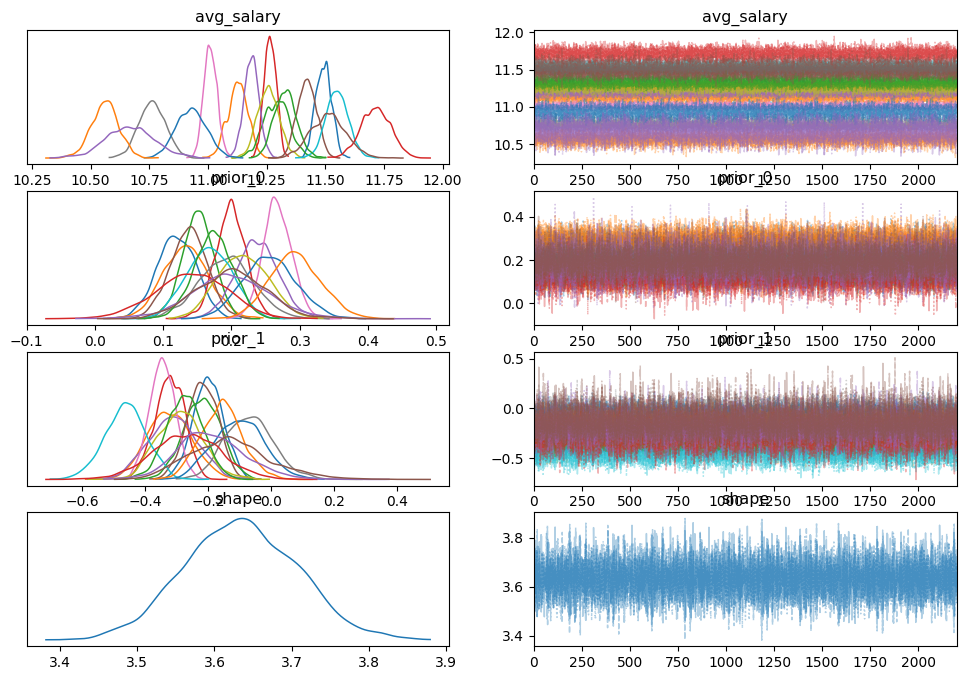

In [217]:
az.plot_trace(trace, var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);

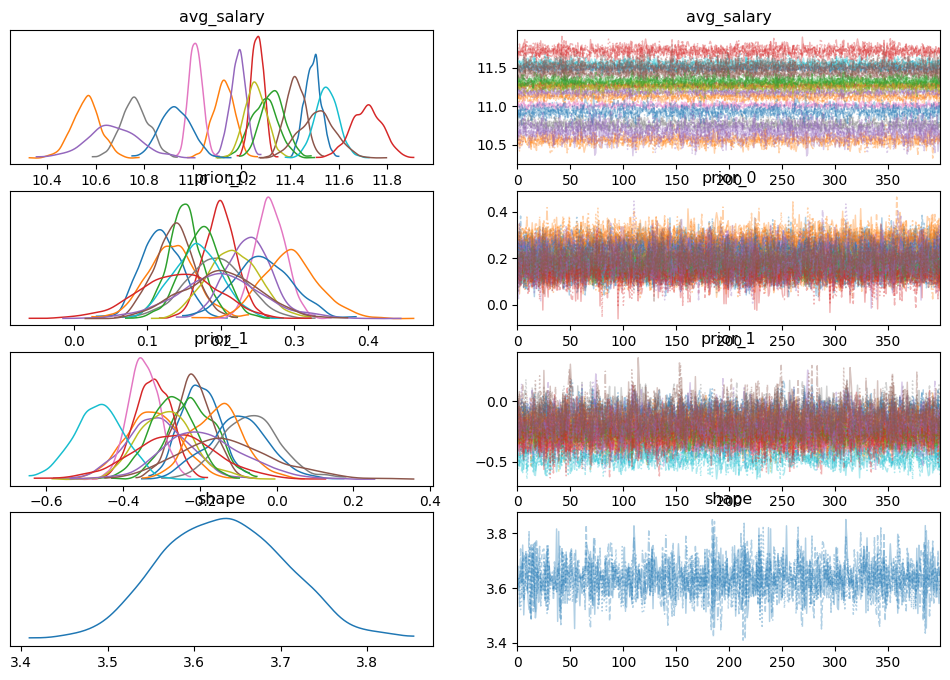

In [215]:
az.plot_trace(trace, var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);

In [211]:
loglikehood.shape

(4, 100, 4515)

In [198]:
# mcmc.__dict__.keys()

In [199]:
# mcmc._states["z"] = samples

In [200]:
# mcmc._states["diverging"] = divergences

In [201]:
trace = az.from_numpyro(mcmc)
dimension = "industry"
posterior_dataset = xr.Dataset(
    data_vars = { var: (["chain", "draw", f"{dimension}"], samples[var]) if len(samples[var].shape)==3 else (["chain", "draw"], samples[var]) for var in samples.keys()  },
    coords = { "chain": np.arange(4), "draw": np.arange(200), f"{dimension}": np.arange(industry.max()+1) },
    attrs = dict(
        trace.posterior.attrs,
    )
)
loglike_dataset = xr.Dataset(
    data_vars=dict(
        log_likelihood=(["chain", "draw", "obs"], loglikehood),
    ),
    coords=dict(
        chain=np.arange(4),
        draw=np.arange(200),
        obs=np.arange(4515),
    ),
    attrs=dict(
        trace.log_likelihood.attrs,
    )
)
sample_stats = xr.Dataset(
    data_vars=dict(
        diverging=(["chain", "draw"], divergences),
    ),
    coords=dict(
        chain=np.arange(4),
        draw=np.arange(200),
    ),
    attrs=dict(
        trace.sample_stats.attrs,
    )
)
observed_data = xr.Dataset(
    data_vars=dict(
        salary=(["obs"], target),
    ),
    coords=dict(
        obs=np.arange(4515),
    ),
    attrs=dict(
        trace.observed_data.attrs,
    )
)
        

trace_2 = az.InferenceData(posterior=posterior_dataset,
                 log_likelihood=loglike_dataset,
                 sample_stats=sample_stats,
                 observed_data=observed_data)

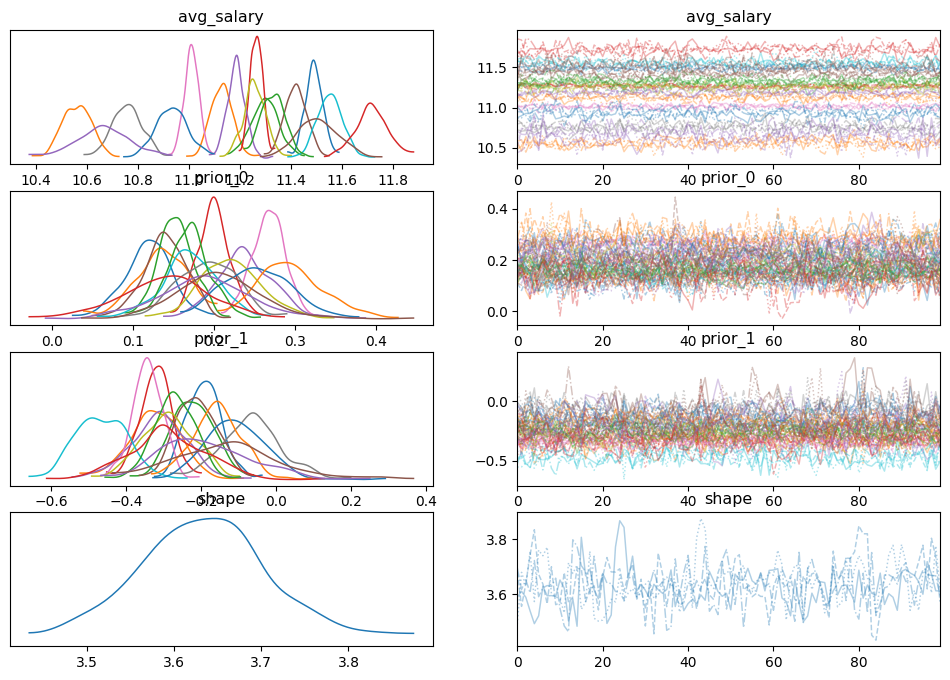

In [202]:
az.plot_trace(trace, var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);

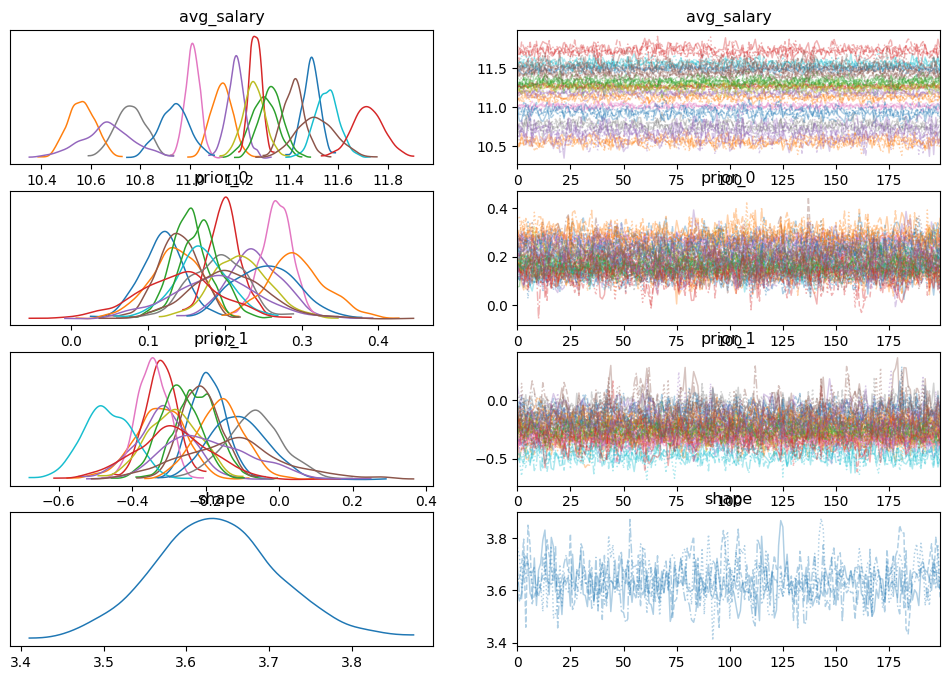

In [203]:
az.plot_trace(trace_2, var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);

In [185]:
trace.observed_data["salary_hat"]

<xarray.DataArray 'salary_hat' (salary_hat_dim_0: 4515)>
array([ 87547.83693844, 100517.88685524,  59662.2296173 , ...,
       214005.82362729,  11997.29617304,  71335.27454243])
Coordinates:
  * salary_hat_dim_0  (salary_hat_dim_0) int64 0 1 2 3 4 ... 4511 4512 4513 4514

In [192]:
((target != trace.observed_data["salary_hat"].values) * 1).sum()

0

In [30]:
samples["avg_salary"].shape

(4, 200, 16)

In [34]:
az.from_numpyro(mcmc)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [24]:
# mcmc.last_state.z["avg_salary"] = 0
az.summary(az.from_numpyro(mcmc))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
avg_salary[0]     11.490  0.036  11.423   11.554      0.001    0.001   
avg_salary[1]     11.126  0.043  11.048   11.212      0.002    0.001   
avg_salary[2]     11.296  0.052  11.210   11.405      0.002    0.002   
avg_salary[3]     11.265  0.026  11.214   11.306      0.001    0.001   
avg_salary[4]     11.189  0.034  11.122   11.243      0.001    0.001   
...                  ...    ...     ...      ...        ...      ...   
prior_1[15]       -0.126  0.145  -0.379    0.170      0.013    0.009   
shape              3.635  0.074   3.499    3.778      0.003    0.002   
sigma_0            0.136  0.040   0.077    0.220      0.002    0.002   
sigma_1            0.741  0.587   0.003    1.809      0.059    0.042   
sigma_avg_salary   0.067  0.021   0.028    0.106      0.002    0.001   

                  ess_bulk  ess_tail  r_hat  
avg_salary[0]        594.0     547.0   1.00  
avg_salary[1]        463.0     686.0   1.00  
avg_salary[2]        504.0     655.0   1.00  
avg_salary[3]        724.0     667.0   1.00  
avg_salary[4]        860.0     423.0   1.01  
...                    ...       ...    ...  
prior_1[15]           82.0     220.0   1.06  
shape                867.0     315.0   1.00  
sigma_0              254.0     430.0   1.03  
sigma_1               49.0      26.0   1.06  
sigma_avg_salary     118.0      80.0   1.01  

[87 rows x 9 columns]

In [ ]:
mcmc.get_extra_fields(group_by_chain=True)["diverging"]

In [138]:
jnp.concatenate([samples[0]["avg_salary"],samples[1]["avg_salary"]], axis=1)

Array([35825.7888407 , 35813.84051329, 35811.50326791, 35824.27507923],      dtype=float64)

In [139]:
concat_sample = samples[0]
for sample in samples[1:]:
    for key in sample.keys():
        concat_sample[key] = jnp.concatenate([concat_sample[key], sample[key]], axis=1)

In [205]:
divergences

Array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [213]:
az.from_dict(samples, sample_stats={"diverging": divergences})

Inference data with groups:
	> posterior
	> sample_stats

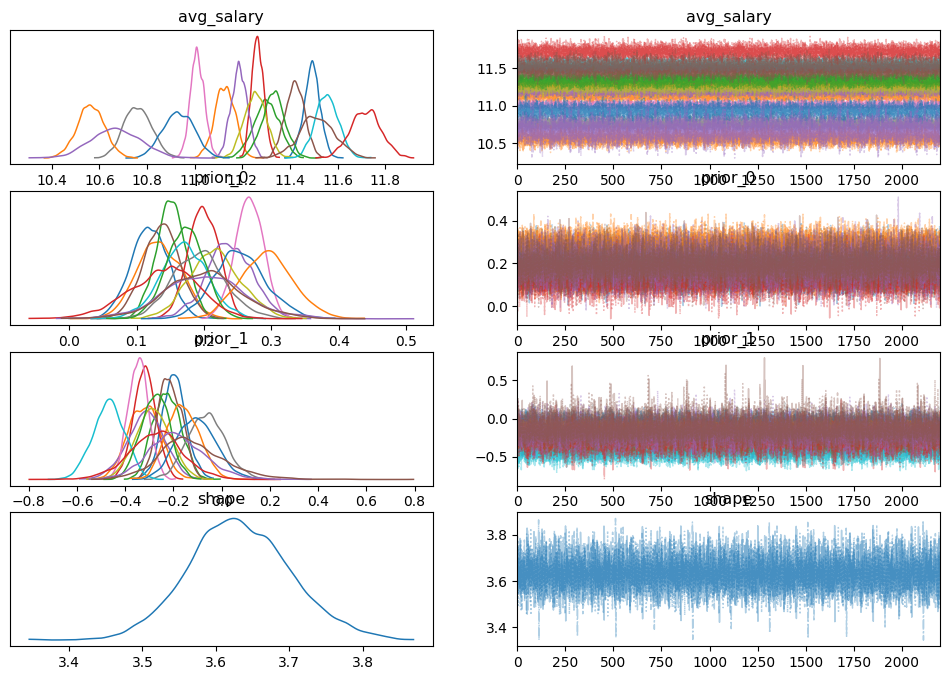

In [220]:
az.plot_trace(az.from_dict(samples, sample_stats={"diverging": divergences}), var_names=["~mu_","~sigma_","~offset"], filter_vars="like", combined=True);

In [198]:
mcmc._states["diverging"].shape

(4, 100)

In [196]:
dd

(400,)

In [175]:
W = jnp.var(concat_sample["mu_avg_salary"], axis=1).sum(axis=0)/4
W

Array(0.00026184, dtype=float64)

In [177]:
B = (400/3)*((jnp.mean(concat_sample["mu_avg_salary"], axis=1) - jnp.mean(concat_sample["mu_avg_salary"], axis=(1,0))) ** 2).sum(axis=0)
B

Array(0.05219246, dtype=float64)

In [178]:
Var = (1-(1/400))*W + (1/400)*B
Var

Array(0.00039166, dtype=float64)

In [179]:
jnp.sqrt(Var/W)

Array(1.22304125, dtype=float64)

In [ ]:
az.plot(t)

In [168]:
summary = az.summary(az.from_numpyro(mcmc))
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
avg_salary[0]     11.491  0.034  11.428   11.552      0.004    0.003   
avg_salary[1]     11.121  0.044  11.029   11.194      0.002    0.002   
avg_salary[2]     11.296  0.051  11.200   11.384      0.003    0.002   
avg_salary[3]     11.266  0.026  11.219   11.313      0.002    0.001   
avg_salary[4]     11.186  0.030  11.128   11.243      0.002    0.001   
...                  ...    ...     ...      ...        ...      ...   
prior_1[15]       -0.125  0.135  -0.374    0.133      0.021    0.015   
shape              3.636  0.072   3.496    3.761      0.004    0.003   
sigma_0            0.137  0.039   0.073    0.214      0.003    0.002   
sigma_1            0.741  0.585   0.015    1.777      0.109    0.078   
sigma_avg_salary   0.066  0.018   0.037    0.104      0.003    0.002   

                  ess_bulk  ess_tail  r_hat  
avg_salary[0]         90.0     260.0   1.04  
avg_salary[1]        332.0     408.0   1.00  
avg_salary[2]        213.0     278.0   1.00  
avg_salary[3]        258.0     217.0   1.01  
avg_salary[4]        361.0     171.0   1.00  
...                    ...       ...    ...  
prior_1[15]           35.0     136.0   1.08  
shape                386.0     288.0   1.01  
sigma_0              128.0     234.0   1.01  
sigma_1               26.0      29.0   1.12  
sigma_avg_salary      29.0     203.0   1.09  

[87 rows x 9 columns]

In [174]:
az.summary(az.from_numpyro(mcmc), var_names=["avg_salary"], round_to=7)

mean        sd     hdi_3%    hdi_97%  mcse_mean  \
avg_salary[0]   11.490936  0.033799  11.428433  11.552017   0.003641   
avg_salary[1]   11.121172  0.044477  11.029437  11.193511   0.002459   
avg_salary[2]   11.295820  0.050668  11.199899  11.383520   0.003472   
avg_salary[3]   11.266219  0.026483  11.219111  11.313346   0.001617   
avg_salary[4]   11.185803  0.029598  11.128376  11.243441   0.001568   
avg_salary[5]   11.422523  0.041516  11.341770  11.495327   0.003312   
avg_salary[6]   11.008153  0.028063  10.961813  11.065060   0.001980   
avg_salary[7]   10.762659  0.057816  10.660802  10.860757   0.003729   
avg_salary[8]   11.257454  0.047565  11.179460  11.356517   0.003961   
avg_salary[9]   11.555681  0.044882  11.473526  11.639700   0.002341   
avg_salary[10]  10.932315  0.065327  10.808744  11.046203   0.005347   
avg_salary[11]  10.561901  0.059023  10.457196  10.678311   0.004536   
avg_salary[12]  11.332114  0.048469  11.230413  11.411171   0.004614   
avg_salary[13]  11.724185  0.066583  11.607630  11.838421   0.003627   
avg_salary[14]  10.672193  0.104678  10.473420  10.859364   0.014018   
avg_salary[15]  11.513845  0.081872  11.366375  11.684828   0.004274   

                 mcse_sd    ess_bulk    ess_tail     r_hat  
avg_salary[0]   0.002584   89.629606  260.351999  1.041797  
avg_salary[1]   0.001741  332.089865  407.579124  1.003653  
avg_salary[2]   0.002459  213.247970  277.950573  1.003432  
avg_salary[3]   0.001145  257.746593  216.574943  1.005891  
avg_salary[4]   0.001110  360.782383  171.070603  1.003243  
avg_salary[5]   0.002347  152.088707  234.729529  1.021202  
avg_salary[6]   0.001402  202.570122  144.607617  1.013813  
avg_salary[7]   0.002640  238.809621  289.734379  1.012721  
avg_salary[8]   0.002806  145.734232  271.847821  1.011393  
avg_salary[9]   0.001657  357.666206  339.860128  1.004195  
avg_salary[10]  0.003796  158.892143  167.048210  1.016664  
avg_salary[11]  0.003214  172.528821  347.875023  1.025518  
avg_salary[12]  0.003272  110.641042  169.177768  1.019780  
avg_salary[13]  0.002567  341.845309  295.706371  1.022546  
avg_salary[14]  0.009965   54.756921  190.196397  1.054226  
avg_salary[15]  0.003028  375.345448  163.084663  1.018644

In [171]:
summary[summary["r_hat"] > 1.1]

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_avg_salary  0.202  0.019   0.166    0.240      0.005    0.004      13.0   
offset_0[0]   -1.261  0.520  -2.236   -0.246      0.106    0.076      24.0   
offset_0[2]   -0.814  0.473  -1.716    0.033      0.106    0.076      20.0   
offset_0[3]   -0.111  0.448  -0.819    0.823      0.107    0.077      19.0   
offset_0[5]   -1.009  0.516  -2.113   -0.080      0.104    0.074      25.0   
offset_0[6]    1.135  0.521   0.261    2.019      0.102    0.073      25.0   
offset_0[8]    0.325  0.603  -0.836    1.402      0.106    0.075      32.0   
offset_0[12]  -0.414  0.495  -1.314    0.588      0.092    0.066      30.0   
offset_0[15]   0.184  0.884  -1.589    1.801      0.232    0.167      15.0   
offset_1[1]   -0.423  0.601  -1.455    0.723      0.117    0.084      28.0   
offset_1[12]  -0.218  0.493  -1.133    0.738      0.094    0.068      28.0   
offset_1[13]  -0.398  0.760  -1.779    0.926      0.190    0.137      16.0   
offset_1[14]   0.474  0.921  -0.982    2.286      0.222    0.180      18.0   
prior_0[15]    0.210  0.055   0.113    0.321      0.011    0.008      27.0   
prior_1[13]   -0.305  0.107  -0.501   -0.095      0.027    0.021      16.0   
prior_1[14]   -0.184  0.141  -0.406    0.088      0.037    0.027      16.0   
sigma_1        0.741  0.585   0.015    1.777      0.109    0.078      26.0   

               ess_tail  r_hat  
mu_avg_salary      31.0   1.28  
offset_0[0]        57.0   1.13  
offset_0[2]        78.0   1.15  
offset_0[3]        36.0   1.20  
offset_0[5]        80.0   1.12  
offset_0[6]       104.0   1.12  
offset_0[8]        56.0   1.11  
offset_0[12]       67.0   1.11  
offset_0[15]       40.0   1.22  
offset_1[1]       142.0   1.11  
offset_1[12]       79.0   1.11  
offset_1[13]      134.0   1.19  
offset_1[14]       47.0   1.17  
prior_0[15]       105.0   1.11  
prior_1[13]        70.0   1.20  
prior_1[14]        54.0   1.19  
sigma_1            29.0   1.12

In [88]:
mcmc.__dict__.keys()

dict_keys(['sampler', '_sample_field', '_default_fields', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'postprocess_fn', 'chain_method', 'progress_bar', '_jit_model_args', '_states', '_states_flat', '_last_state', '_warmup_state', '_init_state_cache', '_cache', '_collection_params', '_args', '_kwargs'])

In [115]:
type(mcmc._last_state.z["avg_salary"])

jaxlib.xla_extension.ArrayImpl

In [116]:
mcmc._states["z"]["avg_salary"] = 0

In [101]:
mcmc.num_samples = 1000

In [117]:
az.from_numpyro(mcmc)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [91]:
4 * 100 * 4515

1806000

In [59]:
samples["avg_salary"].shape

(4, 100, 16)

In [77]:
{ param: jnp.mean(samples[param], axis=(1,)) if len(samples[param].shape)==3 else jnp.mean(samples[param], axis=1) for param in samples.keys() }

{'avg_salary': Array([[11.48713529, 11.10285361, 11.28778919, 11.27517786, 11.18758735,
         11.42353914, 10.99434078, 10.75026861, 11.25726083, 11.58206436,
         10.94528854, 10.57851858, 11.32976709, 11.73276748, 10.74110494,
         11.51557187],
        [11.48306151, 11.13322647, 11.29204287, 11.26266664, 11.18518797,
         11.42796081, 11.01177475, 10.75598618, 11.26175744, 11.54022874,
         10.93024268, 10.55254494, 11.33130849, 11.71330363, 10.65380953,
         11.51429103],
        [11.49565984, 11.13447938, 11.30151926, 11.26325924, 11.18913216,
         11.43763154, 11.00916898, 10.7890252 , 11.25286676, 11.55400418,
         10.93307481, 10.56060639, 11.35102837, 11.72934786, 10.6273985 ,
         11.51566259],
        [11.49148509, 11.12618023, 11.298355  , 11.26986521, 11.18320993,
         11.41949184, 11.01083601, 10.76972375, 11.25499589, 11.55406842,
         10.93365445, 10.56770491, 11.32922617, 11.71121885, 10.70259105,
         11.50409819]], dtype

In [66]:
jnp.mean(samples["avg_salary"], axis=(1,2))

Array([11.19943972, 11.19320533, 11.19623467, 11.19534337], dtype=float64)

In [69]:
for param in samples.keys():
    print(param, samples[param].shape)

avg_salary (4, 100, 16)
mu_0 (4, 100)
mu_1 (4, 100)
mu_avg_salary (4, 100)
offset_0 (4, 100, 16)
offset_1 (4, 100, 16)
prior_0 (4, 100, 16)
prior_1 (4, 100, 16)
shape (4, 100)
sigma_0 (4, 100)
sigma_1 (4, 100)
sigma_avg_salary (4, 100)


In [71]:
{ param: jnp.mean(samples[param], axis=(1,2)) if len(samples[param].shape)==3 else jnp.mean(samples[param], axis=1) for param in samples.keys() }

{'avg_salary': Array([11.19943972, 11.19320533, 11.19623467, 11.19534337], dtype=float64),
 'mu_0': Array([-0.26689651, -0.24538819, -0.23615269, -0.25538926], dtype=float64),
 'mu_1': Array([-1.46011397,  0.07199681,  0.04476531,  0.09087942], dtype=float64),
 'mu_avg_salary': Array([0.2120045 , 0.18278635, 0.20098457, 0.22243084], dtype=float64),
 'offset_0': Array([-0.2104723 ,  0.12671601, -0.1200571 , -0.35821852], dtype=float64),
 'offset_1': Array([ 0.02956252,  0.03328308, -0.02964331,  0.11468568], dtype=float64),
 'prior_0': Array([0.19937528, 0.19086234, 0.19221033, 0.19420409], dtype=float64),
 'prior_1': Array([-0.2647499 , -0.24008223, -0.2424657 , -0.24078777], dtype=float64),
 'shape': Array([3.62683409, 3.62465253, 3.62521416, 3.64340464], dtype=float64),
 'sigma_0': Array([0.11300705, 0.14023163, 0.13498943, 0.13418859], dtype=float64),
 'sigma_1': Array([0.72235226, 0.83634047, 0.78900957, 0.59772177], dtype=float64),
 'sigma_avg_salary': Array([0.06199813, 0.0662934

In [21]:
az.from_numpyro(mcmc)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [13]:
az.summary(az.from_numpyro(mcmc), var_names=["avg_salary","prior"], filter_vars="like")

W0000 00:00:1696352770.200046   34398 hlo_rematerialization.cc:2946] Can't reduce memory use below 607.84MiB (637370193 bytes) by rematerialization; only reduced to 1.21GiB (1302208000 bytes), down from 1.21GiB (1302208000 bytes) originally
W0000 00:00:1696352770.216565   34398 hlo_rematerialization.cc:2946] Can't reduce memory use below 607.84MiB (637370193 bytes) by rematerialization; only reduced to 1.21GiB (1302208000 bytes), down from 1.21GiB (1302208000 bytes) originally
2023-10-03 13:06:20.226461: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB (rounded to 1302208000)requested by op 
2023-10-03 13:06:20.227476: W external/tsl/tsl/framework/bfc_allocator.cc:497] ***************************************************************************************_____________
2023-10-03 13:06:20.227599: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2644] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memor

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1302208000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.21GiB
              constant allocation:         0B
        maybe_live_out allocation:    1.21GiB
     preallocated temp allocation:         0B
                 total allocation:    2.42GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 1.21GiB
		Entry Parameter Subshape: f64[2000,81388]
		==========================

	Buffer 2:
		Size: 1.21GiB
		XLA Label: fusion
		Shape: f64[2,1000,81388]
		==========================



In [13]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(pooled, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4, chain_method='vectorized', progress_bar=True)
sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
features_shard = jax.device_put(features, sharding.reshape(2, 1))
target_shard = jax.device_put(target, sharding.reshape(2))
mcmc.run(jax.random.PRNGKey(0), features_shard, target_shard)

sample: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


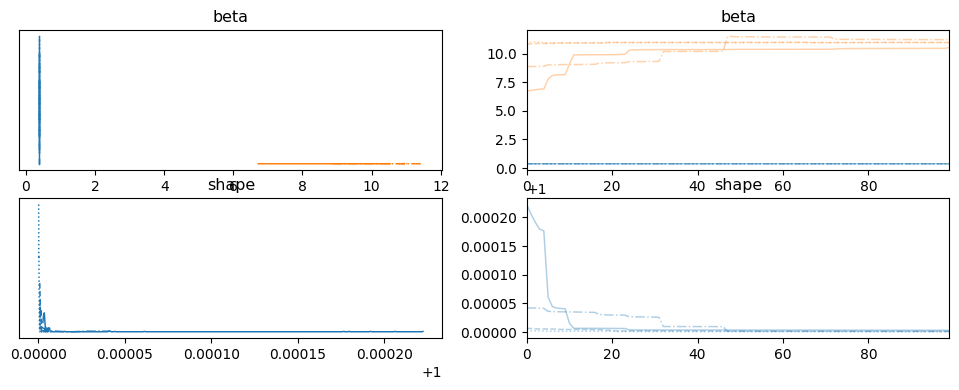

In [12]:
az.plot_trace(trace); 

In [33]:
import jax
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

X = np.random.randn(128, 3)
y = np.random.randn(128)

def model(X, y):
    beta = numpyro.sample("beta", dist.Normal(0, 1), sample_shape=(X.shape[1],))
    numpyro.sample("obs", dist.Normal(X @ beta, 1), obs=y)

mcmc = MCMC(NUTS(model), num_warmup=10000, num_samples=10000)
sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
X_shard = jax.device_put(X, sharding.reshape(2, 1))
y_shard = jax.device_put(y, sharding.reshape(2))
mcmc.run(jax.random.PRNGKey(0), X_shard, y_shard)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
class CustomKDEDistribution(dist.Distribution):
    
    def __init__(self, data, validate_args=False):
        data = np.array(data).flatten()
        self.kde = gaussian_kde(data)  
        self.x_points = np.linspace(np.min(data) - 1, np.max(data) + 1, 100000)
        self.pdf_estimated = self.kde.evaluate(self.x_points)  
        self.cdf_estimated = jnp.cumsum(self.pdf_estimated) / jnp.sum(self.pdf_estimated) # Normalized
        self._batch_shape = ()
        self.support = dist.constraints.real
        super(CustomKDEDistribution, self).__init__(batch_shape=self._batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        # Generating samples using inverse transform sampling
        uniform_samples = random.uniform(key, sample_shape + self._batch_shape)
        samples = jnp.interp(uniform_samples, self.cdf_estimated, self.x_points)
        return samples

    def log_prob(self, value):
        # Validating the input sample
        validate_sample(value)
        
        # Getting the log probability using the KDE estimated PDF
        # Use linear interpolation to get the PDF values at the given points
        pdf_values_at_value = jnp.interp(value, self.x_points, self.pdf_estimated)
        log_prob = jnp.log(pdf_values_at_value)
        return log_prob

NOTE: This class is an implementation (in progress) of the online learning process

In [8]:
class GammaGML():
    def __init__(self, name, parameters, target_var, dataset, year=None, standardize_vars=[], online_learning=False):
        self.name = name
        self.target = target_var
        self.priors = {
            "normal": dist.Normal,
            "uniform": dist.Uniform,
            "beta": dist.Beta,
            "gamma": dist.Gamma,
            "poisson": dist.Poisson,
            "student_t": dist.StudentT,
            "halfnormal": dist.HalfNormal,
            "halfcauchy": dist.HalfCauchy,
            "exponential": dist.Exponential,
            "laplace": dist.Laplace}
        self.vars = {}
        self.dimensions = []
        self.year = year
        self.online_learning = online_learning

        self.get_var_dims(parameters)
        self.data_processing(dataset, standardize_vars, year)
        self.get_plates()
        self.get_coords_dims()

    def __repr__(self):
        if self.year is not None:
            return f"Model: {self.name} - params: {list(self.vars.keys())} - year: {self.year}"
        else:
            return f"Model: {self.name} - params: {list(self.vars.keys())}"
    
    def standardize_var(self, variable):
        variable = (variable - variable.mean()) / variable.std()
        return variable

    def get_var_dims(self, parameters):
        # Create vars and dimensions attributes
        for var, params in parameters.items():
            self.vars[var] = params

            if params.get("dims") is not None:
                self.dimensions += [ dim for dim in params.get("dims") if dim not in self.dimensions ]

    def get_coords_dims(self):
        # Get coords and dims attributes for Arviz
        coords = { coord[0]: list(coord[1]) for coord in self.dimensions }
        dims = {}
        for var in self.vars.keys():
            if self.vars[var]["type"] == "intercept":
                var_name = f"{var}"
            elif self.vars[var]["type"] == "slope":
                var_name = f"beta_{var}"

            if self.vars[var]["dims"] is not None:
                dims[var_name] = [f"{dim}" for dim in self.vars[var]["dims"]]
        
        self.coords = coords
        self.dims = dims

    def data_processing(self, dataset, standardize_vars, year):
        # Data processing
        self.dataset = dataset.to_records(index=False)
        if year is not None:
            if 'year' in self.dataset.dtype.names:
                self.dataset = self.dataset[self.dataset["year"] == year]
                self.dataset = drop_fields(self.dataset, "year")
            else:
                raise ValueError("year is not a column in the dataset")
            
        for var in standardize_vars:
            self.dataset[var] = self.standardize_var(self.dataset[var])

        for var_id, var  in enumerate(self.dimensions):
            coord, coord_idx = np.unique(self.dataset[var], return_inverse=True)
            self.dimensions[var_id] = (var, coord)
            self.dataset = drop_fields(self.dataset, var)
            self.dataset = append_fields(self.dataset, var, coord_idx, usemask=False)

    def get_prior_name(self, var):
        # Prior name
        if self.vars[var]["type"] == "intercept":
            prior_name = f"{var}"
        elif self.vars[var]["type"] == "slope":
            prior_name = f"beta_{var}"
        else:
            prior_name = f"{var}"
        return prior_name
    
    def get_dist_params(self, var, prior_name, last_trace=None):
        if self.vars[var]["hyperprior"]:
            dist_params = self.build_hyperprior(var, prior_name)
        elif self.vars[var]["dist"] == "custom":
            dist_params = last_trace.posterior[prior_name].values
        else:
            dist_params = self.vars[var]["initial_values"]
        return dist_params

    def get_plates(self):
        # Create plates
        self.plates = {}
        self.plates[None] = {"vars": [ var for var, params in self.vars.items() if params["dims"] is None ]}
        for dim, dim_categories in self.dimensions:
            self.plates[dim] = {"vars": [ var for var, params in self.vars.items() if dim in list(params["dims"] if params["dims"] is not None else []) ]}
            self.plates[dim]["dimensions"] = dim_categories
    
    def build_hyperprior(self, var, prior_name):
        hyperpriors = {}
        if self.vars[var]["dist"] == "laplace":
            lambda_class = self.priors["halfcauchy"]
            lambda_prior = lambda_class(scale=10)
            lambda_dist = numpyro.sample(name = f"lambda_{prior_name}", fn = lambda_prior)
            hyperpriors["loc"] = 0
            hyperpriors["scale"] = lambda_dist
        else:
            mu_class = self.priors["normal"]
            sigma_class = self.priors["halfnormal"]
            mu_prior = mu_class(**self.vars[var]["initial_values"])
            sigma_prior = sigma_class(scale=1)

            mu = numpyro.sample(name = f"mu_{prior_name}", fn = mu_prior)
            sigma = numpyro.sample(name = f"sigma_{prior_name}", fn = sigma_prior)
            hyperpriors["loc"] = mu
            hyperpriors["scale"] = sigma

        return hyperpriors

    def build_prior(self, var, prior_name, dist_params):
        distribution_class = self.priors[self.vars[var]["dist"]]
        if self.vars[var]["dist"] == "custom":
            distribution = distribution_class(data=dist_params)
        else:
            distribution = distribution_class(**dist_params)

        if self.vars[var]["parameterization"] == "non-centered-affine":
            prior = numpyro.sample(name = prior_name,
                                fn = dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(**dist_params)))
        elif self.vars[var]["parameterization"] == "non-centered":
            offset = numpyro.sample(name = f"offset_{prior_name}", fn = dist.Normal(loc=0, scale=1))
            prior = numpyro.deterministic(f"{prior_name}", dist_params["loc"] + offset * dist_params["scale"])
        else:
            prior = numpyro.sample(name = prior_name, fn = distribution)
        return prior

    def build(self, last_trace=None):
        def model():
            # Add prior names
            for plate, plate_config in self.plates.items():
                self.plates[plate]["prior_names"] = []
                for var in plate_config["vars"]:
                    prior_name = self.get_prior_name(var)
                    self.plates[plate]["prior_names"].append(prior_name)

            # Add distribution parameters (or hyperpriors)
            for plate, plate_config in self.plates.items():
                self.plates[plate]["dist_params"] = []
                for var in plate_config["vars"]:
                    dist_params = self.get_dist_params(var, plate_config["prior_names"][plate_config["vars"].index(var)], last_trace)
                    self.plates[plate]["dist_params"].append(dist_params)
                    
            # Priors
            mu = 0
            for plate, plate_config in self.plates.items():
                if plate is None:
                    for var in plate_config["vars"]:
                        prior_name = plate_config["prior_names"][plate_config["vars"].index(var)]
                        dist_params = plate_config["dist_params"][plate_config["vars"].index(var)]
                        # Priors  
                        if var == "shape":
                            shape = self.build_prior(var, prior_name, dist_params)
                        elif self.vars[var]["type"] == "intercept":
                            prior = self.build_prior(var, prior_name, dist_params)
                            mu += prior
                        else:
                            prior = self.build_prior(var, prior_name, dist_params)
                            mu += prior * self.dataset[var]
                        
                else:
                     # Hyperpriors should be outside the plate
                    with numpyro.plate(plate, len(plate_config["dimensions"])):
                        for var in plate_config["vars"]:
                            prior_name = plate_config["prior_names"][plate_config["vars"].index(var)]
                            dist_params = plate_config["dist_params"][plate_config["vars"].index(var)]
                            if self.vars[var]["type"] == "intercept":
                                prior = self.build_prior(var, prior_name, dist_params)
                                mu += prior[self.dataset[plate]]
                            else:
                                prior = self.build_prior(var, prior_name, dist_params)
                                mu += prior[self.dataset[plate]] * self.dataset[var]
                                
            mu = jnp.exp(mu)
            rate = shape / mu    

            with numpyro.plate("data", len(self.dataset)):
                likelihood = numpyro.sample(self.target, dist.Gamma(concentration=shape, rate=rate), obs=self.dataset[self.target])

        return model
    
    def add_unconstrained_vars(self, trace):
        for var in trace.posterior.data_vars:
            if var not in ['shape']:
                new_var_name = f"{var}_unconstrained"
                trace.posterior = trace.posterior.assign({new_var_name: np.exp(trace.posterior[var])})
        return trace

    def run_model(self, model, draws=4000, warmup=4000, chains=4, target_accept_prob=0.95, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', progress_bar=progress_bar)
        mcmc.run(rng_key)
        trace = az.from_numpyro(mcmc, coords=self.coords, dims=self.dims)
        trace = self.add_unconstrained_vars(trace)
        return mcmc

In [9]:
params = {
    'avg_salary_ind': {"type": "intercept", "dist": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry"], "hyperprior": False, "parameterization": "centered"},
    'exp': {"type": "slope", "dist": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry"], "hyperprior": False, "parameterization": "centered"},
    'shape': {"type": "shape", "dist": "uniform", "initial_values": {"low": 0, "high": 100}, "dims": None, "hyperprior": False, "parameterization": "centered"}
}

gamma = GammaGML('test', dataset=dataset, parameters=params, target_var="salary", standardize_vars=["exp","age","tenure"], year=2010)
gamma

Model: test - params: ['avg_salary_ind', 'exp', 'shape'] - year: 2010

In [10]:
model = gamma.build()

In [11]:
# mcmc = gamma.run_model(model, warmup=10, draws=10)

In [12]:
import jax
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [13]:
dataset = dataset.loc[dataset.index[:-4]].copy()

In [14]:
dataset["exp"] = (dataset["exp"] - dataset["exp"].mean()) / dataset["exp"].std()
dataset["age"] = (dataset["age"] - dataset["age"].mean()) / dataset["age"].std()
dataset["tenure"] = (dataset["tenure"] - dataset["tenure"].mean()) / dataset["tenure"].std()

In [15]:
X = dataset[["exp", "elementary_edu", "highschool_edu", "postsec_edu", "undergrad_edu", "graduate_edu",
         "grad_highschool_refyear", "grad_college_refyear", "grad_univ_refyear", "tenure", "union", "part_time",
         "public_sector", "self_emp", "age"]].values
y = dataset["salary"].values


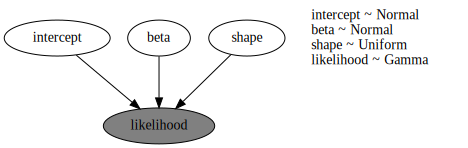

In [17]:
def test(X, y):
    intercept = numpyro.sample("intercept", dist.Normal(10, 1))
    beta = numpyro.sample("beta", dist.Normal(0, 1).expand([15]))
    shape = numpyro.sample("shape", dist.Uniform(1, 100))

    mu = jnp.exp(X @ beta + intercept)
    rate = shape / mu

    likelihood = numpyro.sample("likelihood", dist.Gamma(concentration=shape, rate=rate), obs=y)

numpyro.render_model(test,render_distributions=True, model_args=(X, y))

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=True)
# mcmc.run(rng_key)
sharding = PositionalSharding(mesh_utils.create_device_mesh((8,)))
X_shard = jax.device_put(X, sharding.reshape(8, 1))
y_shard = jax.device_put(y, sharding.reshape(8))
mcmc.run(jax.random.PRNGKey(0), X_shard, y_shard)

I0000 00:00:1696096532.515648   25298 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-09-30 13:55:32.520295: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [17]:
az.summary(az.from_numpyro(mcmc))

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    0.005   0.867  -1.449    0.832      0.433    0.331       4.0   
beta[1]   -0.854   0.767  -1.829    0.260      0.382    0.293       4.0   
beta[2]   -0.037   1.281  -1.699    1.268      0.639    0.490       4.0   
beta[3]    0.123   0.969  -1.291    1.440      0.484    0.370       4.0   
beta[4]    0.163   1.000  -0.832    1.790      0.499    0.382       4.0   
beta[5]   -0.389   1.085  -1.224    1.470      0.542    0.415       4.0   
beta[6]   -0.639   0.793  -1.890    0.313      0.396    0.303       4.0   
beta[7]   -0.275   0.790  -1.043    0.925      0.394    0.302       4.0   
beta[8]    0.544   0.826  -0.673    1.659      0.412    0.316       4.0   
beta[9]    0.028   0.096  -0.131    0.127      0.048    0.037       4.0   
beta[10]  -0.542   1.244  -1.893    1.155      0.621    0.476       4.0   
beta[11]  -0.116   0.941  -1.690    0.703      0.470    0.360       4.0   
beta[12]   0.326   1.332  -1.925    1.539      0.665    0.509       4.0   
beta[13]  -1.076   0.903  -1.736    0.477      0.450    0.345       4.0   
beta[14]   0.681   0.768  -0.061    1.787      0.383    0.294       4.0   
shape     71.937  18.210  40.759   84.828      9.087    6.960       4.0   

          ess_tail         r_hat  
beta[0]        4.0  5.877474e+15  
beta[1]        4.0  5.877474e+15  
beta[2]        4.0  5.877474e+15  
beta[3]        4.0  5.341631e+15  
beta[4]        4.0  5.877474e+15  
beta[5]        4.0  5.877474e+15  
beta[6]        4.0  5.341631e+15  
beta[7]        4.0  5.877474e+15  
beta[8]        4.0  5.341631e+15  
beta[9]        4.0  5.877474e+15  
beta[10]       4.0  5.341631e+15  
beta[11]       4.0  5.341631e+15  
beta[12]       4.0  5.341631e+15  
beta[13]       4.0  5.341631e+15  
beta[14]       4.0  5.877474e+15  
shape          4.0  5.341631e+15

In [45]:
with open(r"mcmc_model.pickle", "wb") as output_file:
    pickle.dump(mcmc, output_file)

In [27]:
mcmc.get_samples()['avg_salary_ind'].shape

(400,)

In [28]:
trace = az.from_numpyro(mcmc)
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
mcmc.__dict__.keys()

dict_keys(['sampler', '_sample_field', '_default_fields', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'postprocess_fn', 'chain_method', 'progress_bar', '_jit_model_args', '_states', '_states_flat', '_last_state', '_warmup_state', '_init_state_cache', '_cache', '_collection_params', '_args', '_kwargs'])

In [34]:
mcmc.__dict__['num_samples']

10

In [35]:
mcmc.get_samples(group_by_chain=True)

{'age': Array([[ 1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.100

In [36]:
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.post_warmup_state.rng_key)

sample: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


In [37]:
mcmc.get_samples(group_by_chain=True)

{'age': Array([[ 1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492],
        [-1.2464536, -1.2464536, -1.2464536, -1.2464536, -1.2464536,
         -1.2464536, -1.2464536, -1.2464536, -1.2464536, -1.2464536],
        [-0.9462185, -0.9462185, -0.9462185, -0.9462185, -0.9462185,
         -0.9462185, -0.9462185, -0.9462185, -0.9462185, -0.9462185],
        [-1.3384836, -1.3384836, -1.3384836, -1.3384836, -1.3384836,
         -1.3384836, -1.3384836, -1.3384836, -1.3384836, -1.3384836]],      dtype=float32),
 'avg_salary_ind': Array([[-0.11900992, -0.11900992, -0.11900992, -0.11900992, -0.11900992,
         -0.11900992, -0.11900992, -0.11900992, -0.11900992, -0.11900992],
        [-1.060695  , -1.060695  , -1.060695  , -1.060695  , -1.060695  ,
         -1.060695  , -1.060695  , -1.060695  , -1.060695  , -1.060695  ],
        [-1.2875072 , -1.2875072 , -1.2875072 , -1.2875072 , -1.2875072 ,
         -1.2875072 , -1.

In [38]:
mcmc.num_samples = 20

In [39]:
mcmc.run(mcmc.post_warmup_state.rng_key)

sample: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [40]:
mcmc.get_samples()["avg_salary_ind"].shape

(80,)

In [41]:
az.from_numpyro(mcmc)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [58]:
mcmc.sampler

In [274]:
az.summary(mcmc)``

mean     sd  hdi_3%  \
avg_salary_ind[accommodation and food services]     10.557  0.067  10.436   
avg_salary_ind[agriculture]                         10.549  0.101  10.354   
avg_salary_ind[business, building and other sup...  10.805  0.057  10.697   
avg_salary_ind[construction]                        11.101  0.034  11.037   
avg_salary_ind[educational services]                11.308  0.026  11.257   
...                                                    ...    ...     ...   
beta_exp_unconstrained[professional, scientific...   1.191  0.049   1.099   
beta_exp_unconstrained[public administration]        1.118  0.035   1.051   
beta_exp_unconstrained[trade]                        1.339  0.030   1.282   
beta_exp_unconstrained[transportation and wareh...   1.084  0.041   1.010   
beta_exp_unconstrained[utilities]                    1.113  0.082   0.961   

                                                    hdi_97%  mcse_mean  \
avg_salary_ind[accommodation and food services]      10.690      0.001   
avg_salary_ind[agriculture]                          10.732      0.001   
avg_salary_ind[business, building and other sup...   10.911      0.000   
avg_salary_ind[construction]                         11.162      0.000   
avg_salary_ind[educational services]                 11.355      0.000   
...                                                     ...        ...   
beta_exp_unconstrained[professional, scientific...    1.283      0.000   
beta_exp_unconstrained[public administration]         1.180      0.000   
beta_exp_unconstrained[trade]                         1.393      0.000   
beta_exp_unconstrained[transportation and wareh...    1.163      0.000   
beta_exp_unconstrained[utilities]                     1.266      0.001   

                                                    mcse_sd  ess_bulk  \
avg_salary_ind[accommodation and food services]       0.000   11736.0   
avg_salary_ind[agriculture]                           0.001   18628.0   
avg_salary_ind[business, building and other sup...    0.000   16058.0   
avg_salary_ind[construction]                          0.000   18486.0   
avg_salary_ind[educational services]                  0.000   17199.0   
...                                                     ...       ...   
beta_exp_unconstrained[professional, scientific...    0.000   15497.0   
beta_exp_unconstrained[public administration]         0.000   20442.0   
beta_exp_unconstrained[trade]                         0.000   17780.0   
beta_exp_unconstrained[transportation and wareh...    0.000   13785.0   
beta_exp_unconstrained[utilities]                     0.000   14164.0   

                                                    ess_tail  r_hat  
avg_salary_ind[accommodation and food services]       6711.0    1.0  
avg_salary_ind[agriculture]                           6200.0    1.0  
avg_salary_ind[business, building and other sup...    6275.0    1.0  
avg_salary_ind[construction]                          5563.0    1.0  
avg_salary_ind[educational services]                  5388.0    1.0  
...                                                      ...    ...  
beta_exp_unconstrained[professional, scientific...    4907.0    1.0  
beta_exp_unconstrained[public administration]         6044.0    1.0  
beta_exp_unconstrained[trade]                         5093.0    1.0  
beta_exp_unconstrained[transportation and wareh...    6679.0    1.0  
beta_exp_unconstrained[utilities]                     5743.0    1.0  

[65 rows x 9 columns]

In [55]:
import numpyro
import numpyro.distributions as dist

from jax.random import PRNGKey
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

def model(J, sigma, y=None):
    with numpyro.plate("J", J):
        mu = numpyro.sample("mu", dist.Normal(0, 5))
        tau = numpyro.sample("tau", dist.HalfCauchy(5))

        theta = numpyro.sample("theta", dist.Normal(mu, tau))
    numpyro.sample("y", dist.Normal(theta, sigma), obs=y)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method="parallel")
mcmc.run(PRNGKey(0), **eight_school_data, extra_fields=["num_steps", "energy"])

numpyro_data = az.from_numpyro(
    mcmc,
    coords={"asdf": ["uno","dos","tres","cuatro","cinco","seis","siete","ocho"]},
    dims={"theta": ["asdf"], "mu": ["asdf"], "tau": ["asdf"]},
)
numpyro_data

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [19]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
gamma.dimensions

[('industry',
  array(['accommodation and food services', 'agriculture',
         'business, building and other support services', 'construction',
         'educational services',
         'finance, insurance, real estate and leasing',
         'forestry, fishing, mining, oil and gas',
         'health care and social assistance',
         'information, culture and recreation', 'manufacturing',
         'other services',
         'professional, scientific and technical services',
         'public administration', 'trade', 'transportation and warehousing',
         'utilities'], dtype=object))]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_', 'lambda_', 'offset_'] have not been found and will be ignored
  warnings.warn(


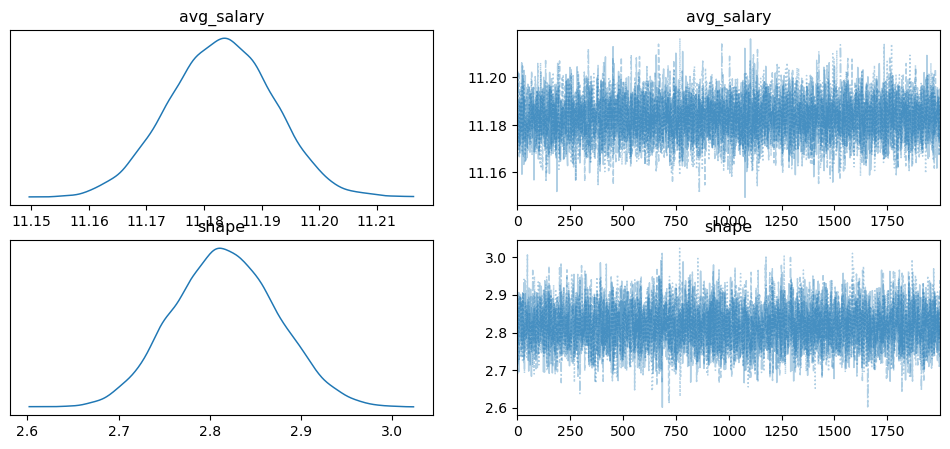

In [113]:
az.plot_trace(trace, combined=True, var_names=["~mu_","~sigma_","~lambda_","~offset_"], filter_vars="like", figsize=(12, 5));

In [114]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [115]:
params2 = {
    'avg_salary_ind': {"type": "intercept", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'exp': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'sex': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'undergrad_edu': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'graduate_edu': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'union': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'part_time': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    'shape': {"type": "shape", "dist": "uniform", "initial_values": {"low": 0, "high": 100}, "dims": None, "hyperprior": False, "parameterization": "centered"}
}

gamma2 = GammaGML('test', dataset=dataset, parameters=params2, target_var="salary", standardize_vars=["exp","age","tenure"], year=2011)
gamma2

Model: test - params: ['avg_salary_ind', 'shape'] - year: 2011

In [116]:
model2 = gamma2.build(last_trace=trace)

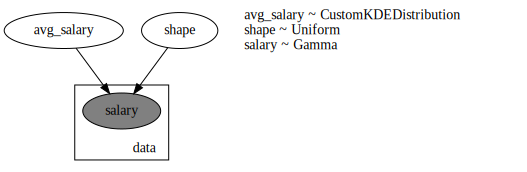

In [117]:
numpyro.render_model(model2, render_distributions=True)

In [118]:
trace2 = gamma2.run_model(model2, warmup=10000, draws=10000)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_', 'lambda_', 'offset_'] have not been found and will be ignored
  warnings.warn(


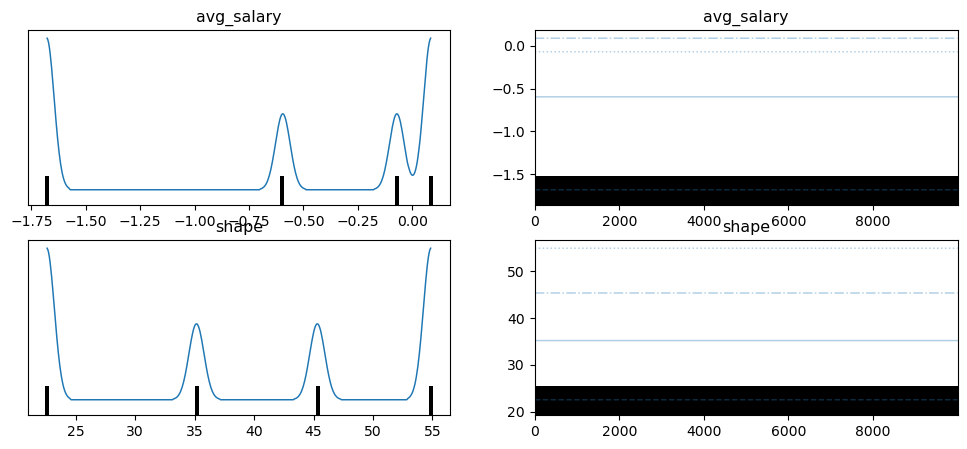

In [104]:
az.plot_trace(trace2, combined=True, var_names=["~mu_","~sigma_","~lambda_","~offset_"], filter_vars="like", figsize=(12, 5));

<Axes: ylabel='Density'>

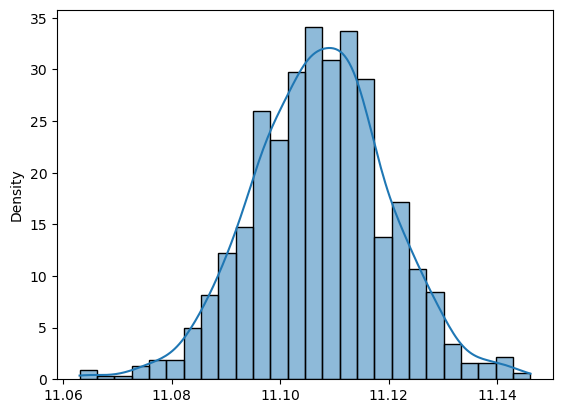

In [48]:
import jax
key = jax.random.PRNGKey(0)
dist_test = CustomKDEDistribution(data=trace.posterior["avg_salary"].values)
a = dist_test.sample(key, (1000,))
sns.histplot(a, kde=True, stat="density")

In [29]:
az.summary(trace, var_names=["~mu_","~sigma_"], filter_vars="like").to_csv("summary_lasso.csv")

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_'] have not been found and will be ignored
  warnings.warn(


In [119]:
dataset = data[data["year"]==2011][["year","industry","elementary_edu","highschool_edu","postsec_edu","undergrad_edu","graduate_edu","exp","salary"]].copy()

In [120]:
dataset.industry = dataset.industry.astype("category")

In [121]:
# Standardize exp
dataset.exp = (dataset.exp - dataset.exp.mean()) / dataset.exp.std()
dataset.exp

917      1.040478
918      0.220954
919      0.384859
924     -0.024903
925      0.139001
           ...   
87013   -1.172237
87014   -0.844427
87015    0.712668
87016   -1.336141
87017   -1.336141
Name: exp, Length: 4515, dtype: float64

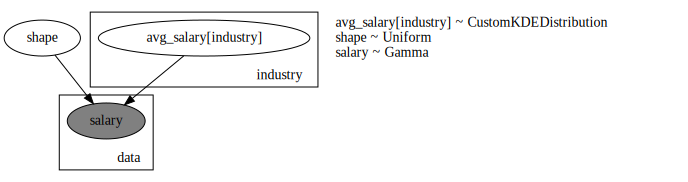

In [122]:
def test():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        avg_salary = numpyro.sample("avg_salary[industry]", CustomKDEDistribution(data=trace.posterior["avg_salary"].values))
        # exp = numpyro.sample("exp", dist.Normal(loc=0, scale=1))
        # elementary_edu = numpyro.sample("elementary_edu", dist.Normal(loc=0, scale=1))
        # highschool_edu = numpyro.sample("highschool_edu", dist.Normal(loc=0, scale=1))
        # postsec_edu = numpyro.sample("postsec_edu", dist.Normal(loc=0, scale=1))
        # undergrad_edu = numpyro.sample("undergrad_edu", dist.Normal(loc=0, scale=1))
        # graduate_edu = numpyro.sample("graduate_edu", dist.Normal(loc=0, scale=1))

    mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values]) #+ exp[dataset.industry.cat.codes.values] * dataset.exp.values +\
        # elementary_edu[dataset.industry.cat.codes.values] * dataset.elementary_edu.values +\
        # highschool_edu[dataset.industry.cat.codes.values] * dataset.highschool_edu.values +\
        # postsec_edu[dataset.industry.cat.codes.values] * dataset.postsec_edu.values +\
        # undergrad_edu[dataset.industry.cat.codes.values] * dataset.undergrad_edu.values +\
        # graduate_edu[dataset.industry.cat.codes.values] * dataset.graduate_edu.values)
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test, render_distributions=True)

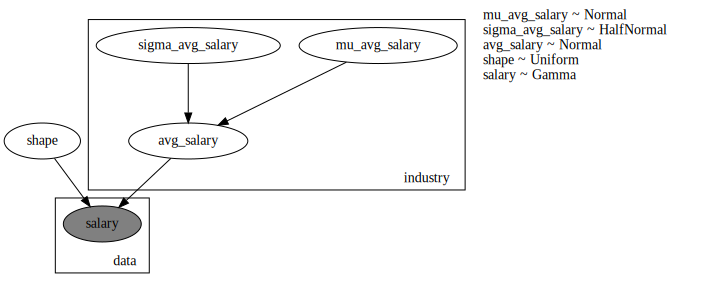

In [23]:
def test_hyper():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
        sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
        avg_salary = numpyro.sample("avg_salary", dist.Normal(loc=mu_avg_salary, scale=sigma_avg_salary))
        mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values])
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test_hyper, render_distributions=True)

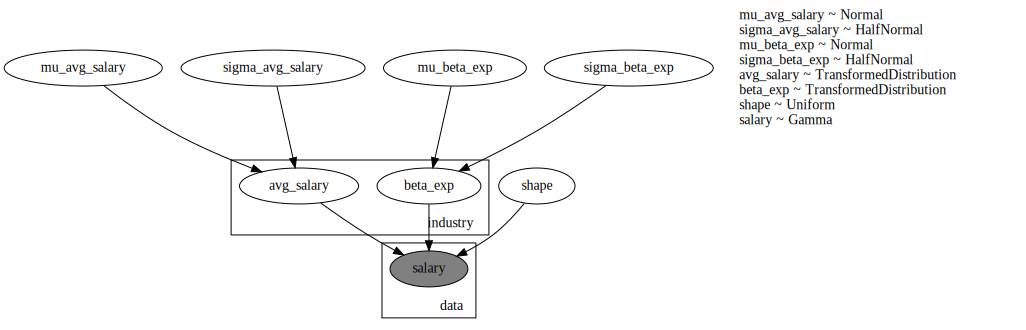

In [78]:
def test_hyper_nc():
    mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
    sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
    mu_beta_exp = numpyro.sample("mu_beta_exp", dist.Normal(loc=0, scale=1))
    sigma_beta_exp = numpyro.sample("sigma_beta_exp", dist.HalfNormal(scale=1))

    with numpyro.plate("industry", len(dataset.industry.unique())):
        avg_salary = numpyro.sample("avg_salary", dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(loc=mu_avg_salary, scale=sigma_avg_salary)))
        
        beta_exp = numpyro.sample("beta_exp", dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(loc=mu_beta_exp, scale=sigma_beta_exp)))
        
        mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values] + beta_exp[dataset.industry.cat.codes.values] * dataset.exp.values)
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test_hyper_nc, render_distributions=True)

In [123]:
def run_model(model, draws=4000, warmup=4000, chains=4, target_accept_prob=0.95, postprocess_fn=None, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=progress_bar)
        mcmc.run(rng_key)
        trace = az.from_numpyro(mcmc)
        return trace

trace = run_model(test)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


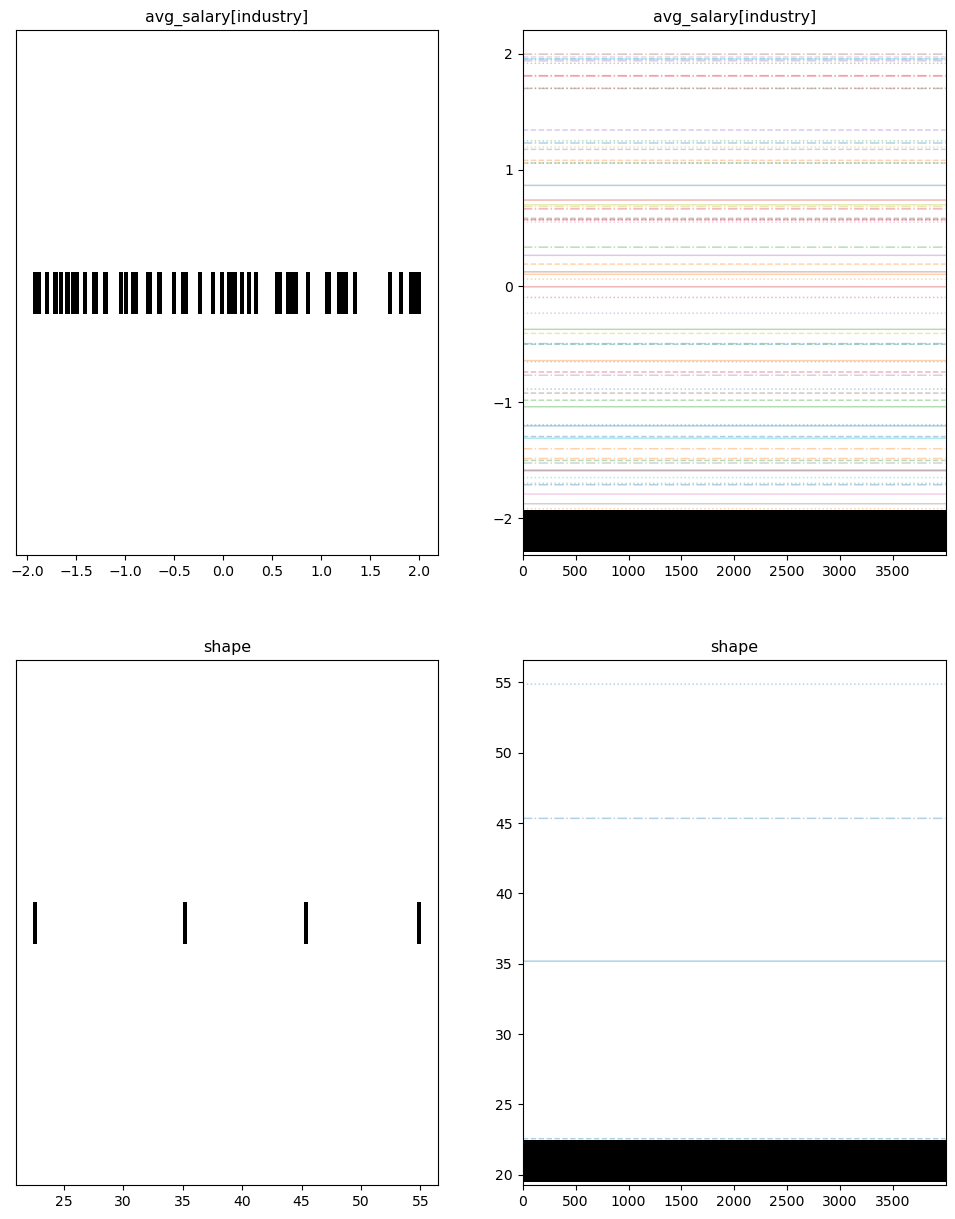

In [124]:
az.plot_trace(trace, filter_vars="like", figsize=(12, 15));

In [53]:
az.summary(trace, filter_vars="like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
avg_salary[industry][0]   10.317  0.039  10.243   10.388        0.0      0.0   
avg_salary[industry][1]   10.606  0.062  10.490   10.724        0.0      0.0   
avg_salary[industry][2]   10.788  0.049  10.700   10.883        0.0      0.0   
avg_salary[industry][3]   10.950  0.031  10.888   11.005        0.0      0.0   
avg_salary[industry][4]   11.173  0.024  11.129   11.217        0.0      0.0   
avg_salary[industry][5]   11.048  0.029  10.994   11.102        0.0      0.0   
avg_salary[industry][6]   11.492  0.058  11.384   11.604        0.0      0.0   
avg_salary[industry][7]   10.893  0.020  10.853   10.930        0.0      0.0   
avg_salary[industry][8]   11.047  0.034  10.983   11.108        0.0      0.0   
avg_salary[industry][9]   11.125  0.015  11.099   11.154        0.0      0.0   
avg_salary[industry][10]  10.740  0.033  10.680   10.804        0.0      0.0   
avg_salary[industry][11]  11.138  0.032  11.075   11.196        0.0      0.0   
avg_salary[industry][12]  11.150  0.025  11.104   11.197        0.0      0.0   
avg_salary[industry][13]  10.828  0.019  10.794   10.863        0.0      0.0   
avg_salary[industry][14]  10.980  0.033  10.918   11.041        0.0      0.0   
avg_salary[industry][15]  11.366  0.057  11.259   11.474        0.0      0.0   
exp[0]                     0.255  0.038   0.183    0.328        0.0      0.0   
exp[1]                     0.051  0.054  -0.053    0.151        0.0      0.0   
exp[2]                     0.300  0.053   0.201    0.400        0.0      0.0   
exp[3]                     0.216  0.033   0.153    0.277        0.0      0.0   
exp[4]                     0.236  0.027   0.186    0.287        0.0      0.0   
exp[5]                     0.170  0.033   0.108    0.230        0.0      0.0   
exp[6]                     0.121  0.056   0.015    0.225        0.0      0.0   
exp[7]                     0.160  0.025   0.113    0.205        0.0      0.0   
exp[8]                     0.248  0.039   0.173    0.320        0.0      0.0   
exp[9]                     0.193  0.015   0.164    0.220        0.0      0.0   
exp[10]                    0.270  0.036   0.203    0.337        0.0      0.0   
exp[11]                    0.150  0.035   0.086    0.216        0.0      0.0   
exp[12]                    0.131  0.029   0.078    0.186        0.0      0.0   
exp[13]                    0.302  0.020   0.265    0.340        0.0      0.0   
exp[14]                    0.196  0.035   0.129    0.261        0.0      0.0   
exp[15]                    0.179  0.071   0.042    0.308        0.0      0.0   
shape                      3.458  0.059   3.351    3.574        0.0      0.0   

                          ess_bulk  ess_tail  r_hat  
avg_salary[industry][0]    23946.0   13089.0    1.0  
avg_salary[industry][1]    35307.0   12595.0    1.0  
avg_salary[industry][2]    30582.0   12381.0    1.0  
avg_salary[industry][3]    33022.0   10866.0    1.0  
avg_salary[industry][4]    32614.0   12750.0    1.0  
avg_salary[industry][5]    36102.0   10916.0    1.0  
avg_salary[industry][6]    29759.0   12586.0    1.0  
avg_salary[industry][7]    30927.0   11642.0    1.0  
avg_salary[industry][8]    34637.0   11462.0    1.0  
avg_salary[industry][9]    33333.0   12224.0    1.0  
avg_salary[industry][10]   34872.0   11178.0    1.0  
avg_salary[industry][11]   35621.0   11898.0    1.0  
avg_salary[industry][12]   34339.0   12394.0    1.0  
avg_salary[industry][13]   34000.0   12258.0    1.0  
avg_salary[industry][14]   35955.0   12694.0    1.0  
avg_salary[industry][15]   31024.0   13453.0    1.0  
exp[0]                     25227.0   12637.0    1.0  
exp[1]                     34330.0   11451.0    1.0  
exp[2]                     30888.0   13019.0    1.0  
exp[3]                     33177.0   11261.0    1.0  
exp[4]                     34778.0   11280.0    1.0  
exp[5]                     35785.0   12271.0    1.0  
exp[6]                     28807.0   14046.0    1.0  
exp[7]     

In [244]:
dataset.occup.cat.codes.values

array([8, 9, 2, ..., 7, 8, 7], dtype=int8)

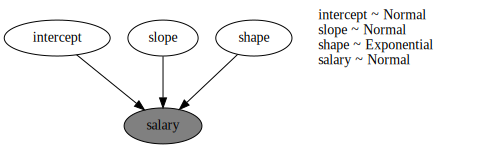

In [245]:
def test():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1), sample_shape=(len(dataset.industry.unique()),))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()),))

    mu = intercept[dataset.industry.cat.codes.values] + slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test, render_distributions=True)

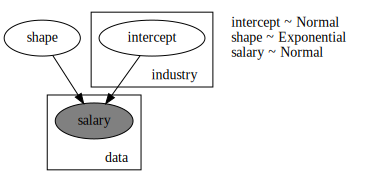

In [246]:
def test_plate():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        intercept = numpyro.sample("intercept", dist.Normal(0, 1))
        # slope = numpyro.sample("slope", dist.Normal(0, 1))

    mu = intercept[dataset.industry.cat.codes.values] #+ slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_plate, render_distributions=True)

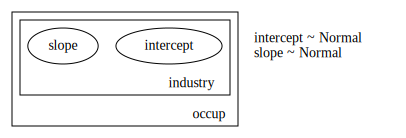

In [301]:
def test_nested_plate():
    with numpyro.plate("occup", len(dataset.occup.unique())), numpyro.plate("industry", len(dataset.industry.unique())):
            intercept = numpyro.sample("intercept", dist.Normal(0, 1))
            slope = numpyro.sample("slope", dist.Normal(0, 1))

    #         mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    # sigma = numpyro.sample("shape", dist.Exponential(1))

    # numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested_plate, render_distributions=True)

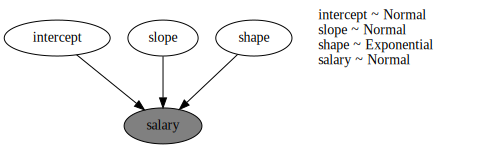

In [358]:
def test_nested():
    intercept = numpyro.sample("intercept", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))

    mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested, render_distributions=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

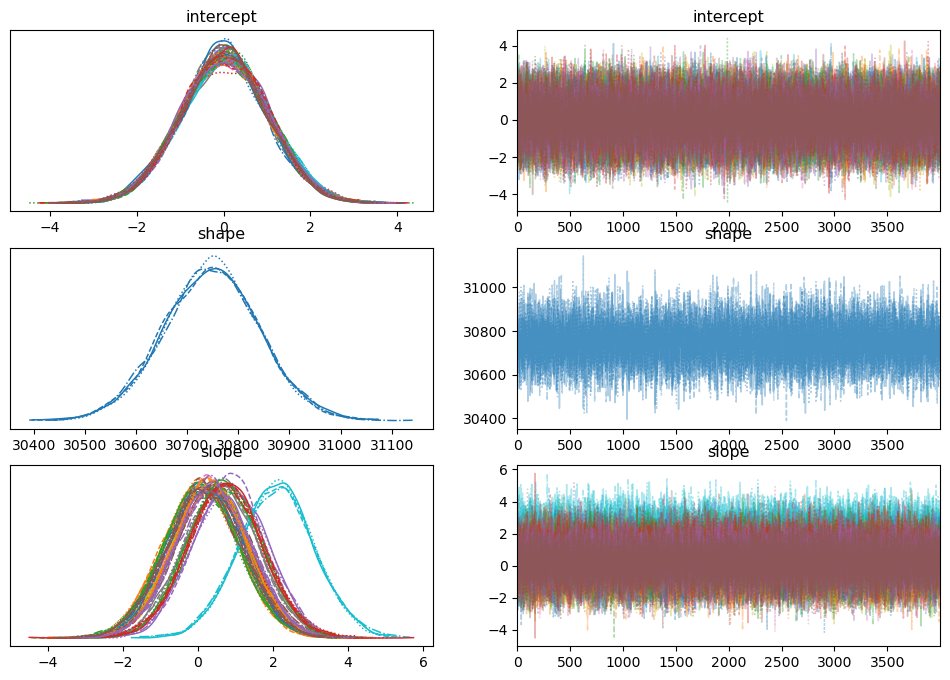

In [60]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

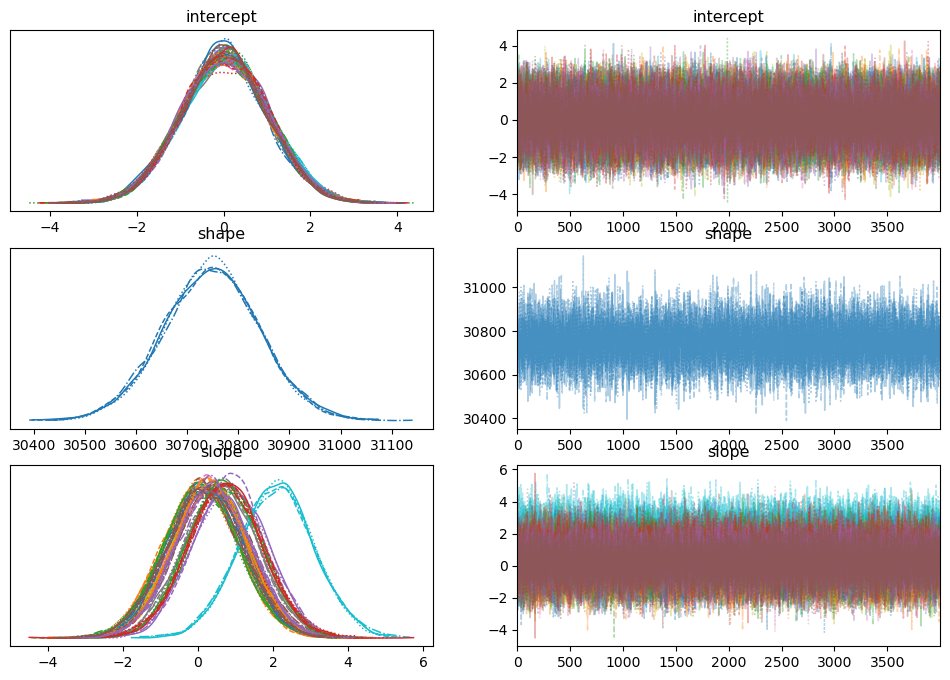

In [61]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

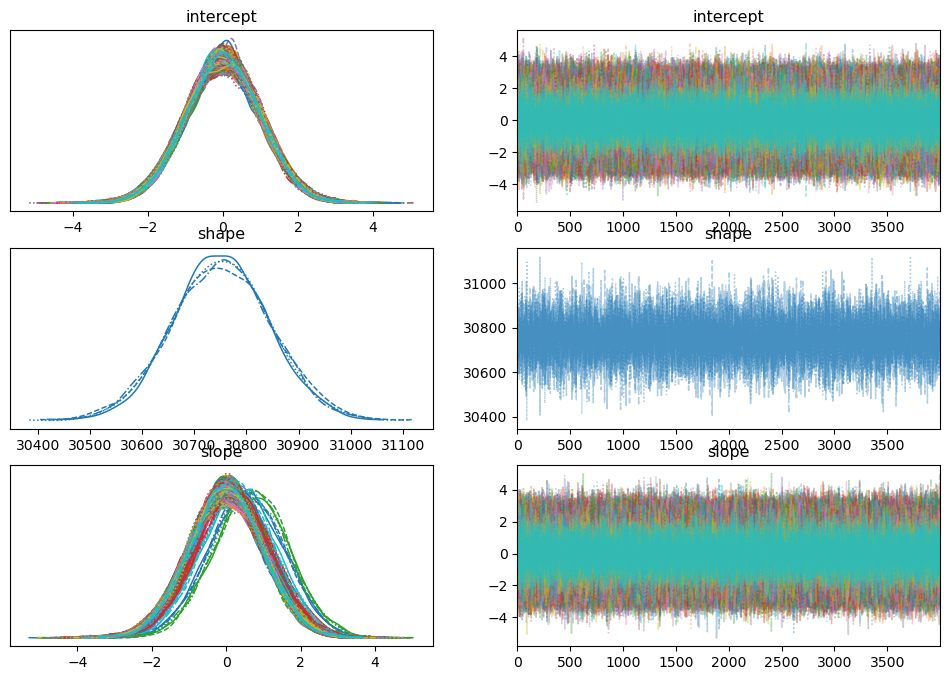

In [84]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_nested_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

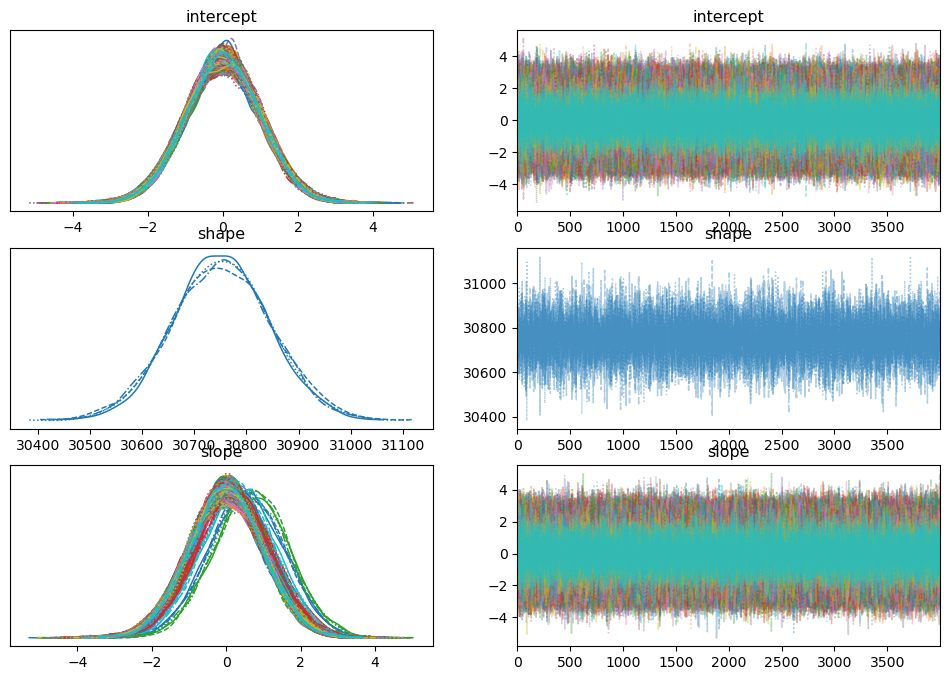

In [85]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested = az.from_numpyro(mcmc)
az.plot_trace(trace_nested, figsize=(12, 8));

In [86]:
az.summary(trace_nested_plate).head(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept[0, 0]   0.012  0.988  -1.805    1.936      0.005    0.009   44827.0   
intercept[0, 1]  -0.001  1.006  -1.893    1.852      0.005    0.010   40616.0   
intercept[0, 2]   0.010  1.013  -1.853    1.952      0.005    0.010   42472.0   
intercept[0, 3]  -0.001  1.004  -1.922    1.835      0.005    0.010   42412.0   
intercept[0, 4]   0.004  0.987  -1.827    1.857      0.005    0.010   39464.0   
intercept[0, 5]  -0.005  1.001  -1.854    1.914      0.005    0.010   41871.0   
intercept[0, 6]  -0.007  1.000  -1.926    1.844      0.005    0.010   41179.0   
intercept[0, 7]  -0.007  0.991  -1.835    1.897      0.005    0.009   37735.0   
intercept[0, 8]   0.013  1.003  -1.888    1.846      0.005    0.010   40485.0   
intercept[0, 9]   0.002  1.003  -1.849    1.907      0.005    0.010   46605.0   
intercept[0, 10] -0.004  1.000  -1.881    1.896      0.005    0.010   40349.0   
intercept[0, 11]  0.010  1.008  -1.967    1.836      0.005    0.010   45843.0   
intercept[0, 12]  0.001  0.988  -1.836    1.923      0.005    0.010   42577.0   
intercept[0, 13] -0.008  0.999  -1.908    1.851      0.005    0.010   39269.0   
intercept[0, 14]  0.011  0.998  -1.874    1.839      0.005    0.010   40296.0   
intercept[0, 15] -0.004  1.000  -1.903    1.846      0.005    0.010   41991.0   
intercept[0, 16] -0.003  0.998  -1.897    1.873      0.005    0.010   44826.0   
intercept[0, 17]  0.004  0.982  -1.838    1.871      0.005    0.010   43438.0   
intercept[0, 18] -0.005  1.002  -1.894    1.816      0.005    0.010   44489.0   
intercept[0, 19]  0.005  1.007  -1.916    1.867      0.005    0.011   44761.0   

                  ess_tail  r_hat  
intercept[0, 0]    11117.0    1.0  
intercept[0, 1]    10659.0    1.0  
intercept[0, 2]    10600.0    1.0  
intercept[0, 3]    11069.0    1.0  
intercept[0, 4]    10357.0    1.0  
intercept[0, 5]    10820.0    1.0  
intercept[0, 6]    11035.0    1.0  
intercept[0, 7]    10888.0    1.0  
intercept[0, 8]    10114.0    1.0  
intercept[0, 9]    11088.0    1.0  
intercept[0, 10]   10756.0    1.0  
intercept[0, 11]   11376.0    1.0  
intercept[0, 12]   10437.0    1.0  
intercept[0, 13]   10562.0    1.0  
intercept[0, 14]   10675.0    1.0  
intercept[0, 15]   11189.0    1.0  
intercept[0, 16]   11249.0    1.0  
intercept[0, 17]   10940.0    1.0  
intercept[0, 18]   11189.0    1.0  
intercept[0, 19]    9851.0    1.0

In [87]:
az.summary(trace_nested).head(20)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept[0, 0]   0.012  0.988  -1.805    1.936      0.005    0.009   44827.0   
intercept[0, 1]  -0.001  1.006  -1.893    1.852      0.005    0.010   40616.0   
intercept[0, 2]   0.010  1.013  -1.853    1.952      0.005    0.010   42472.0   
intercept[0, 3]  -0.001  1.004  -1.922    1.835      0.005    0.010   42412.0   
intercept[0, 4]   0.004  0.987  -1.827    1.857      0.005    0.010   39464.0   
intercept[0, 5]  -0.005  1.001  -1.854    1.914      0.005    0.010   41871.0   
intercept[0, 6]  -0.007  1.000  -1.926    1.844      0.005    0.010   41179.0   
intercept[0, 7]  -0.007  0.991  -1.835    1.897      0.005    0.009   37735.0   
intercept[0, 8]   0.013  1.003  -1.888    1.846      0.005    0.010   40485.0   
intercept[0, 9]   0.002  1.003  -1.849    1.907      0.005    0.010   46605.0   
intercept[0, 10] -0.004  1.000  -1.881    1.896      0.005    0.010   40349.0   
intercept[0, 11]  0.010  1.008  -1.967    1.836      0.005    0.010   45843.0   
intercept[0, 12]  0.001  0.988  -1.836    1.923      0.005    0.010   42577.0   
intercept[0, 13] -0.008  0.999  -1.908    1.851      0.005    0.010   39269.0   
intercept[0, 14]  0.011  0.998  -1.874    1.839      0.005    0.010   40296.0   
intercept[0, 15] -0.004  1.000  -1.903    1.846      0.005    0.010   41991.0   
intercept[0, 16] -0.003  0.998  -1.897    1.873      0.005    0.010   44826.0   
intercept[0, 17]  0.004  0.982  -1.838    1.871      0.005    0.010   43438.0   
intercept[0, 18] -0.005  1.002  -1.894    1.816      0.005    0.010   44489.0   
intercept[0, 19]  0.005  1.007  -1.916    1.867      0.005    0.011   44761.0   

                  ess_tail  r_hat  
intercept[0, 0]    11117.0    1.0  
intercept[0, 1]    10659.0    1.0  
intercept[0, 2]    10600.0    1.0  
intercept[0, 3]    11069.0    1.0  
intercept[0, 4]    10357.0    1.0  
intercept[0, 5]    10820.0    1.0  
intercept[0, 6]    11035.0    1.0  
intercept[0, 7]    10888.0    1.0  
intercept[0, 8]    10114.0    1.0  
intercept[0, 9]    11088.0    1.0  
intercept[0, 10]   10756.0    1.0  
intercept[0, 11]   11376.0    1.0  
intercept[0, 12]   10437.0    1.0  
intercept[0, 13]   10562.0    1.0  
intercept[0, 14]   10675.0    1.0  
intercept[0, 15]   11189.0    1.0  
intercept[0, 16]   11249.0    1.0  
intercept[0, 17]   10940.0    1.0  
intercept[0, 18]   11189.0    1.0  
intercept[0, 19]    9851.0    1.0

In [134]:
def model(industry, occupation, experience, salary):
    # Assuming industry and occupation are integer indices
    num_industries = len(set(industry))
    num_occupations = len(set(occupation))
    
    # Priors for the intercept and slope parameters, 
    # with a dimension for each industry and occupation
    with numpyro.plate('industry_occupation_plate', num_industries * num_occupations):
        intercept = numpyro.sample('intercept', dist.Normal(0, 1))
        slope = numpyro.sample('slope', dist.Normal(0, 1))
    
    # Prior for the standard deviation of the residuals
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # Creating an index that represents each combination of industry and occupation
    industry_occupation_index = industry * num_occupations + occupation
    
    # Expected value according to the linear regression model
    mu = intercept[industry_occupation_index] + slope[industry_occupation_index] * experience
    
    # Likelihood of the observed data
    with numpyro.plate('data', len(experience)):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=salary)


In [135]:
numpyro.render_model(model(dataset.industry.values, dataset.postsec_edu.values, dataset.exp.values, dataset.salary.values), render_distributions=True)

AssertionError: 

In [43]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [261]:
a.data_processing(dataset, standardize_vars=["exp"], categorical_vars=["industry"])

In [262]:
a.dataset[a.target]

array([164249.34152766,  46537.31343284,  17109.30640913, ...,
        43747.44897959,  25850.76530612,  13256.80272109])

In [263]:
a.run_model("test", a.dataset, a.target)

intercept {'exp': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
slope {'age': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
error {'sigma': {'prior': 'halfnormal', 'initial_values': {'scale': 1}, 'dims': None}}


NameError: name 'exp' is not defined

In [235]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(a.build())
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)

intercept {'exp': {'prior': 'normal', 'initial_values': {'mu': 0, 'sigma': 1}, 'dims': None}}
['loc', 'scale']


TypeError: Normal.__init__() got an unexpected keyword argument 'reparametrized_params'

In [61]:
a.prior("intercept", "edu", params["intercept"]["edu"])

AssertionError: 

In [48]:
a.data_processing(dataset, year=2011, standardize_vars=["exp"], categorical_vars=["industry","postsec_edu"])

NameError: name 'dataset' is not defined

In [10]:
b.reparametrized_params

[10, 'scale']

In [9]:
b.reparametrized_params[0] = 10

In [367]:
dataset.query("year == 2011")

year                           industry  postsec_edu   exp  \
917    2011              public administration            1  31.0   
918    2011     transportation and warehousing            1  21.0   
919    2011  health care and social assistance            1  23.0   
924    2011  health care and social assistance            1  18.0   
925    2011                      manufacturing            0  20.0   
...     ...                                ...          ...   ...   
87013  2011                       construction            0   4.0   
87014  2011  health care and social assistance            0   8.0   
87015  2011                       construction            1  27.0   
87016  2011                              trade            1   2.0   
87017  2011  health care and social assistance            1   2.0   

              salary  
917     87547.836938  
918    100517.886855  
919     59662.229617  
924     55771.214642  
925    103760.399334  
...              ...  
87013   81062.811980  
87014   74577.787022  
87015  214005.823627  
87016   11997.296173  
87017   71335.274542  

[4515 rows x 5 columns]

In [82]:
np.unique(a.dataset.year)

array([2011])

In [24]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [25]:
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   

In [101]:
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    # avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    print(avg_salary_ind)

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    # mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = avg_salary_ind[model_array["industry"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    print(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])

In [102]:
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace

In [103]:
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=True)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

In [104]:
# parameters = ["exp","sex",{"edu_level":['elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu']},
#     {"grad_refyear":['grad_highschool_refyear','grad_college_refyear','grad_univ_refyear']},'tenure','union','part_time',
#     'public_sector','self_emp',{"firm_size":['firm_size','loc_size']},'age']

parameters = ["exp",'age']

columns = ['salary','industry']
for id_run, param in enumerate(parameters):
    # Append param to columns
    if isinstance(param, dict):
        columns += list(param.values())[0]
    else:
        columns.append(param)

    if id_run == 0:
        model_name = f"M{id_run}-{param}"
    elif isinstance(param, dict):
        model_name = f"M{id_run}-M{id_run-1}+{list(param.keys())[0]}"
    else:
        model_name = f"M{id_run}-M{id_run-1}+{param}"

    trace = run_model(model_name=model_name, dataset=dataset[columns], dependent_var="salary", draws=2000, warmup=2000, chains=4)
                                # target_accept_prob=0.95, postprocess_fn=None)
    print(f"Run {id_run} completed") 

NameError: name 'create_model_arrays' is not defined

In [34]:
trace

NameError: name 'trace' is not defined

In [ ]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=False)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

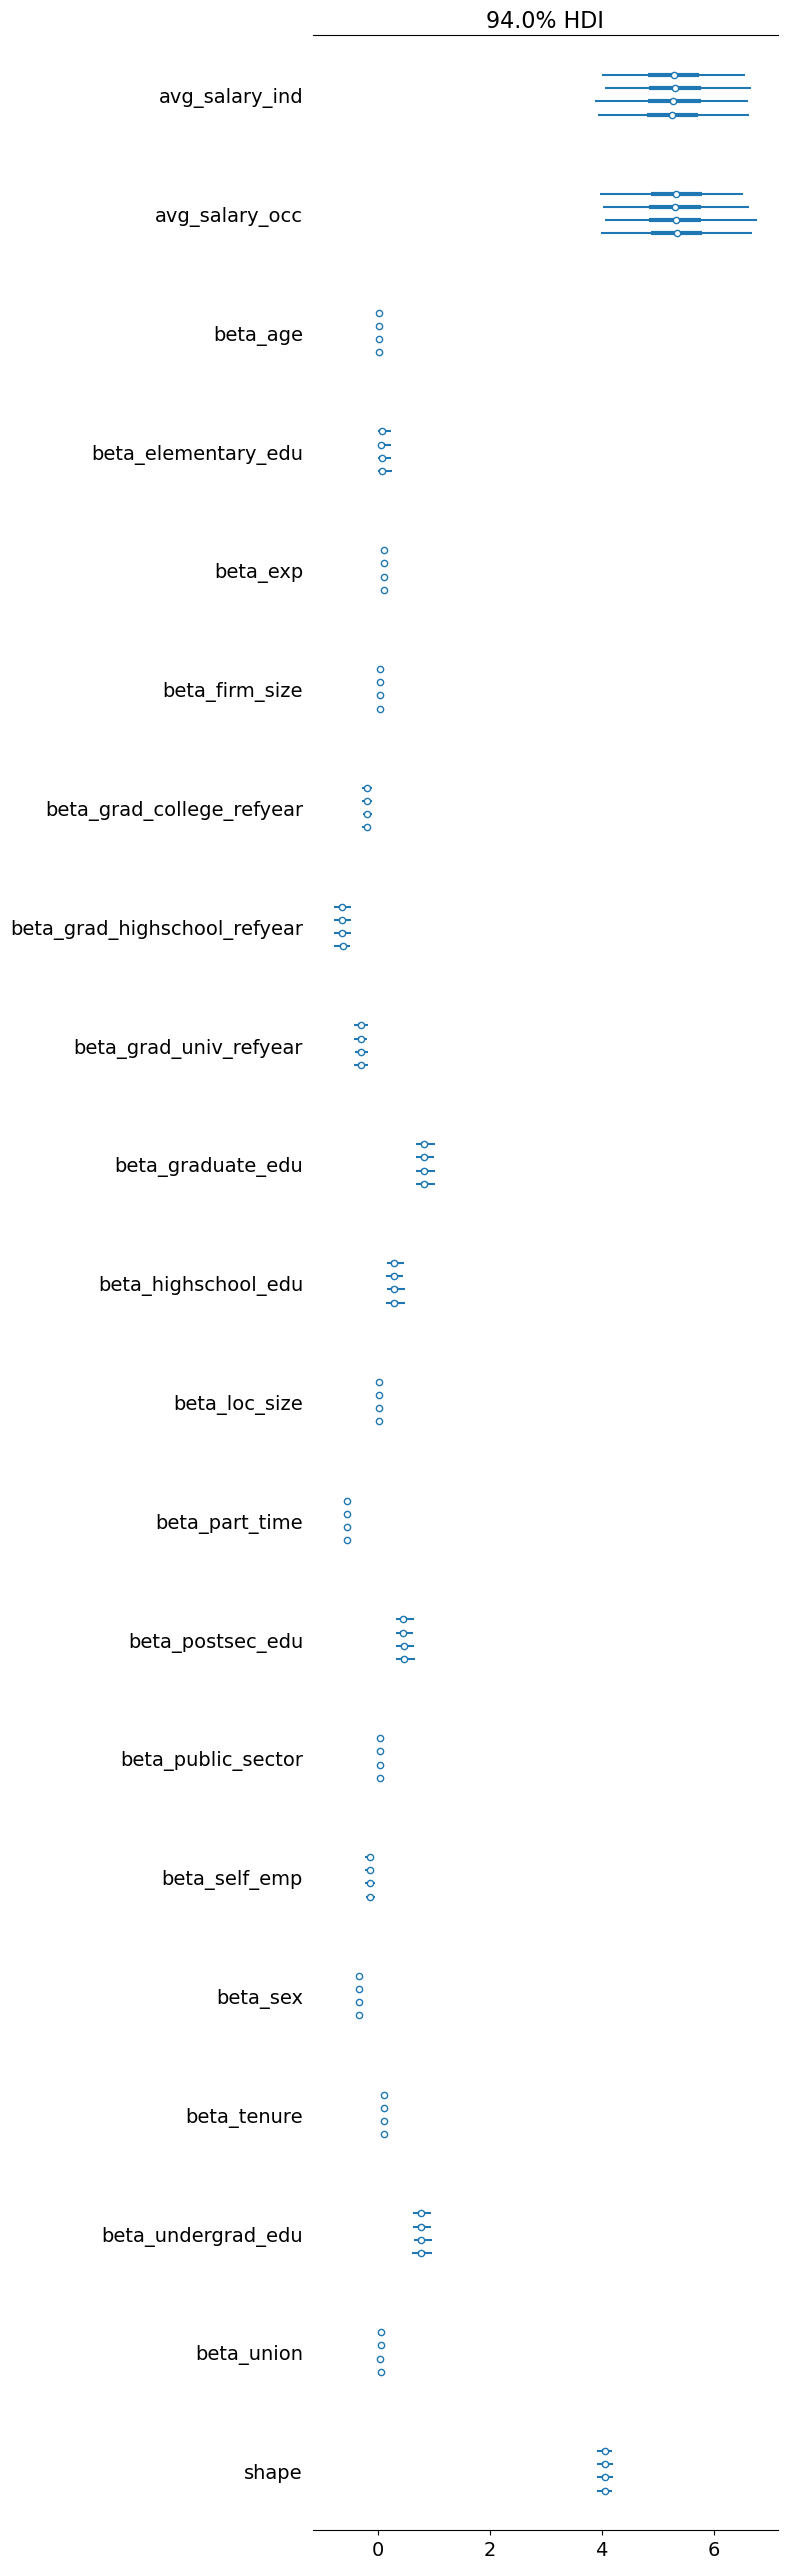

In [45]:
az.plot_forest(trace)

#TODO:
1. Run backward elimination (adding the log calculation) using a for loop
2. Plotting the famous chart to see if adding variables is relevant
3. Run the model with the variables selected but updating the priors

In [281]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
avg_salary_ind                5.276  0.698   3.930    6.585      0.010   
avg_salary_occ                5.312  0.697   3.980    6.622      0.010   
beta_age                      0.020  0.013  -0.002    0.045      0.000   
beta_elementary_edu           0.092  0.080   0.000    0.242      0.002   
beta_exp                      0.110  0.013   0.085    0.133      0.000   
beta_firm_size                0.041  0.006   0.031    0.052      0.000   
beta_grad_college_refyear    -0.192  0.045  -0.272   -0.102      0.000   
beta_grad_highschool_refyear -0.627  0.078  -0.781   -0.485      0.001   
beta_grad_univ_refyear       -0.299  0.066  -0.421   -0.177      0.001   
beta_graduate_edu             0.837  0.092   0.680    1.014      0.002   
beta_highschool_edu           0.305  0.089   0.151    0.472      0.002   
beta_loc_size                 0.033  0.006   0.022    0.044      0.000   
beta_part_time               -0.552  0.025  -0.601   -0.506      0.000   
beta_postsec_edu              0.474  0.089   0.326    0.647      0.002   
beta_public_sector            0.044  0.019   0.008    0.079      0.000   
beta_self_emp                -0.136  0.043  -0.217   -0.056      0.000   
beta_sex                     -0.327  0.015  -0.356   -0.300      0.000   
beta_tenure                   0.121  0.009   0.104    0.137      0.000   
beta_undergrad_edu            0.784  0.090   0.628    0.955      0.002   
beta_union                    0.052  0.016   0.022    0.083      0.000   
shape                         4.052  0.074   3.912    4.190      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
avg_salary_ind                  0.007    4946.0    5164.0    1.0  
avg_salary_occ                  0.007    4853.0    5214.0    1.0  
beta_age                        0.000    5710.0    5474.0    1.0  
beta_elementary_edu             0.001    2185.0    3213.0    1.0  
beta_exp                        0.000    5677.0    5464.0    1.0  
beta_firm_size                  0.000    9246.0    5939.0    1.0  
beta_grad_college_refyear       0.000    9857.0    6221.0    1.0  
beta_grad_highschool_refyear    0.001    9460.0    6047.0    1.0  
beta_grad_univ_refyear          0.001    8599.0    6062.0    1.0  
beta_graduate_edu               0.001    2278.0    3264.0    1.0  
beta_highschool_edu             0.001    2217.0    3276.0    1.0  
beta_loc_size                   0.000   10014.0    6362.0    1.0  
beta_part_time                  0.000    8331.0    6329.0    1.0  
beta_postsec_edu                0.001    2212.0    3300.0    1.0  
beta_public_sector              0.000    7308.0    5940.0    1.0  
beta_self_emp                   0.000    9023.0    6273.0    1.0  
beta_sex                        0.000    8826.0    6120.0    1.0  
beta_tenure                     0.000    7422.0    5831.0    1.0  
beta_undergrad_edu              0.001    2262.0    3529.0    1.0  
beta_union                      0.000    7907.0    6128.0    1.0  
shape                           0.001    8808.0    5892.0    1.0

# Test model

In [15]:
data.shape

(5475, 47)

In [7]:
ind_idx, ind_cats = pd.factorize(data["industry"])
occup_idx, occup_cats = pd.factorize(data["occup"])
exp_idx = jnp.array(data["exp"].values)

elementary_edu_idx = jnp.array(data["elementary_edu"].values)
highschool_edu_idx = jnp.array(data["highschool_edu"].values)
postsec_edu_idx = jnp.array(data["postsec_edu"].values)
undergrad_edu_idx = jnp.array(data["undergrad_edu"].values)
graduate_edu_idx = jnp.array(data["graduate_edu"].values)

grad_highschool_refyear_idx = jnp.array(data["grad_highschool_refyear"].values)
grad_college_refyear_idx = jnp.array(data["grad_college_refyear"].values)
grad_univ_refyear_idx = jnp.array(data["grad_univ_refyear"].values)

public_sector_idx = jnp.array(data["public_sector"].values)
self_emp_idx = jnp.array(data["self_emp"].values)
union_idx = jnp.array(data["union"].values)
part_time_idx = jnp.array(data["part_time"].values)

tenure_idx = jnp.array(data["tenure"].values)
age_idx = jnp.array(data["age"].values)
firm_size_idx = jnp.array(data["firm_size"].values)
loc_size_idx = jnp.array(data["loc_size"].values)
sex_idx = jnp.array(data["sex"].values)

salary_idx = jnp.array(data["salary"].values)

In [269]:
exp_idx = (exp_idx - exp_idx.mean()) / exp_idx.std()
age_idx = (age_idx - age_idx.mean()) / age_idx.std()
tenure_idx = (tenure_idx - tenure_idx.mean()) / tenure_idx.std()

In [270]:
def model():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1))#, sample_shape=(len(ind_cats),))
    occup = numpyro.sample("occup", dist.Normal(10, 1))#, sample_shape=(len(occup_cats),))
    exp = numpyro.sample("exp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    elementary_edu = numpyro.sample("elementary_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    highschool_edu = numpyro.sample("highschool_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    postsec_edu = numpyro.sample("postsec_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    undergrad_edu = numpyro.sample("undergrad_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    graduate_edu = numpyro.sample("graduate_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))

    grad_highschool_refyear = numpyro.sample("grad_highschool_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_college_refyear = numpyro.sample("grad_college_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_univ_refyear = numpyro.sample("grad_univ_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    public_sector = numpyro.sample("public_sector", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    self_emp = numpyro.sample("self_emp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    union = numpyro.sample("union", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    part_time = numpyro.sample("part_time", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    tenure = numpyro.sample("tenure", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    age = numpyro.sample("age", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    firm_size = numpyro.sample("firm_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    loc_size = numpyro.sample("loc_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    sex = numpyro.sample("sex", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    shape = numpyro.sample("shape", dist.Exponential(1))

    mu = jnp.exp(intercept + occup + exp * exp_idx + elementary_edu * elementary_edu_idx + 
                    highschool_edu * highschool_edu_idx + postsec_edu * postsec_edu_idx + 
                    undergrad_edu * undergrad_edu_idx + graduate_edu * graduate_edu_idx +
                    grad_highschool_refyear * grad_highschool_refyear_idx + grad_college_refyear * grad_college_refyear_idx +
                    grad_univ_refyear * grad_univ_refyear_idx + public_sector * public_sector_idx +
                    self_emp * self_emp_idx + union * union_idx + part_time * part_time_idx +
                    tenure * tenure_idx + age * age_idx + firm_size * firm_size_idx +
                    loc_size * loc_size_idx + sex * sex_idx)
                    
    rate = shape / mu

    numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=salary_idx)

In [271]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [272]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model, target_accept_prob=0.95)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples, num_chains=4, chain_method='parallel', postprocess_fn=None)
mcmc.run(rng_key)
# mcmc.print_summary()
# samples = mcmc.get_samples()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [273]:
az.summary(az.from_numpyro(mcmc))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
age                      0.020  0.013  -0.004    0.044      0.000    0.000   
elementary_edu           0.098  0.084   0.000    0.251      0.002    0.001   
exp                      0.109  0.013   0.084    0.133      0.000    0.000   
firm_size                0.041  0.006   0.030    0.052      0.000    0.000   
grad_college_refyear    -0.192  0.045  -0.277   -0.107      0.000    0.000   
grad_highschool_refyear -0.628  0.079  -0.776   -0.480      0.001    0.001   
grad_univ_refyear       -0.298  0.066  -0.422   -0.176      0.001    0.000   
graduate_edu             0.843  0.095   0.685    1.031      0.002    0.002   
highschool_edu           0.310  0.092   0.150    0.486      0.002    0.002   
intercept                5.312  0.694   3.990    6.591      0.010    0.007   
loc_size                 0.033  0.006   0.022    0.044      0.000    0.000   
occup                    5.271  0.694   3.936    6.530      0.010    0.007   
part_time               -0.552  0.026  -0.597   -0.502      0.000    0.000   
postsec_edu              0.480  0.092   0.327    0.660      0.002    0.002   
public_sector            0.044  0.019   0.010    0.080      0.000    0.000   
self_emp                -0.136  0.044  -0.222   -0.059      0.000    0.000   
sex                     -0.328  0.015  -0.355   -0.300      0.000    0.000   
shape                    4.052  0.074   3.915    4.191      0.001    0.001   
tenure                   0.121  0.009   0.104    0.137      0.000    0.000   
undergrad_edu            0.789  0.093   0.632    0.970      0.002    0.002   
union                    0.052  0.016   0.024    0.083      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
age                        5129.0    5060.0    1.0  
elementary_edu             1768.0    3056.0    1.0  
exp                        5226.0    5019.0    1.0  
firm_size                  9431.0    5475.0    1.0  
grad_college_refyear       8817.0    5558.0    1.0  
grad_highschool_refyear    8294.0    5747.0    1.0  
grad_univ_refyear          8724.0    5706.0    1.0  
graduate_edu               1860.0    3137.0    1.0  
highschool_edu             1804.0    3026.0    1.0  
intercept                  4440.0    5319.0    1.0  
loc_size                   9465.0    6098.0    1.0  
occup                      4423.0    4998.0    1.0  
part_time                  7067.0    5263.0    1.0  
postsec_edu                1771.0    2888.0    1.0  
public_sector              6934.0    6174.0    1.0  
self_emp                   8198.0    5214.0    1.0  
sex                        7463.0    6046.0    1.0  
shape                      8866.0    5536.0    1.0  
tenure                     8587.0    6103.0    1.0  
undergrad_edu              1821.0    2910.0    1.0  
union                      7400.0    6171.0    1.0

In [ ]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["intercept","occup","exp","elementary_edu","highschool_edu","postsec_edu",
                                                "undergrad_edu","graduate_edu","shape"],combined=True, figsize=(12, 25));

In [171]:
az.plot_trace(trace, var_names=["avg_salary_ind","avg_salary_occ","beta_exp","beta_elementary_edu","beta_highschool_edu",
                                "beta_postsec_edu","beta_undergrad_edu","beta_graduate_edu","beta_grad_highschool_refyear",
                                "beta_grad_college_refyear","beta_grad_univ_refyear","beta_public_sector","beta_self_emp",
                                "beta_union","beta_part_time","beta_tenure","beta_age","beta_firm_size","beta_loc_size",
                                "beta_sex","shape"],combined=True, figsize=(12, 25));

KeyError: 'var names: "[\'beta_elementary_edu\' \'beta_highschool_edu\' \'beta_postsec_edu\'\\n \'beta_undergrad_edu\' \'beta_graduate_edu\' \'beta_grad_highschool_refyear\'\\n \'beta_grad_college_refyear\' \'beta_grad_univ_refyear\' \'beta_public_sector\'\\n \'beta_self_emp\' \'beta_union\' \'beta_part_time\' \'beta_tenure\' \'beta_age\'\\n \'beta_firm_size\' \'beta_loc_size\' \'beta_sex\'] are not present" in dataset'